# Домашнее задание, модуль по NLP

### Задание 1:

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

 - Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
 - Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
 - Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны.  Получить результаты инференса пайплайнов, и оценить какое из решений лучше.


In [1]:
# Standart libs
import os
import re
import string
import zipfile
import tempfile
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Data
import pandas as pd
import numpy as np
# Sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.decomposition import LatentDirichletAllocation
# Transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
# PyTorch
import torch.optim as optim
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
# Web-parsing
from bs4 import BeautifulSoup
import requests
# Gensim for topic modeling
#from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, CoherenceModel
from gensim import corpora#, models, similarities

In [2]:
# Обработка текста 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to /Users/anetta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anetta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anetta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anetta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.6 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Загрузка данных</h4>
</div>

Загрузим тексты из файлов и присвоим метки классов на основе названий папок.

In [4]:
zip_path = 'bbc.zip'
data_path = 'bbc'

In [5]:
# Разархивируем bbc.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

In [6]:
# Название классов новостных статей
lebels = os.listdir(data_path)

In [7]:
lebels

['entertainment', 'business', 'sport', 'politics', 'tech']

Напишем метод который сложит данные из архива в pd.DataFrame для наглядности.

In [8]:
def load_data(path):
    """Loads text and labels from categorized directories.
    Params:
        path: str
            Path to original data
    Returns:
        pd.DataFrame: 
            Dataset with text and labels
    """
    texts = []
    labels = []
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding='latin-1') as file:
                    texts.append(file.read())
                    labels.append(category)
    return pd.DataFrame({'text': texts, 'label': labels})

In [9]:
# Загрузка данных
df = load_data(data_path)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2221 non-null   object
 1   label   2221 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


In [ ]:
Видим что у нас 2221 новостей и нет нулевых данных.

In [11]:
df.head()

text          label
0  Musicians to tackle US red tape\n\nMusicians' ...  entertainment
1  U2's desire to be number one\n\nU2, who have w...  entertainment
2  Rocker Doherty in on-stage fight\n\nRock singe...  entertainment
3  Snicket tops US box office chart\n\nThe film a...  entertainment
4  Ocean's Twelve raids box office\n\nOcean's Twe...  entertainment

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Предобработка данных</h4>
</div>

Теперь поработаем над текстами новостей. Перед обучением нужно нормализовать тексты, для этого приведем все к нижнему регистру, удалим стоп-слова, удалим именованные сущности, проведем леммантизацию и т.д.

In [12]:
# Пригодится для токенизации
nlp = spacy.load("en_core_web_sm")

In [13]:
def preprocess_text(text):
    """
    Cleans the text by removing punctuation, stop words, 
    and performing lemmatization, converts text to lowercase.

    Parameters:
    text (str): The input text to be processed.

    Returns:
    str: The normalized text.
    """
    # Убираем мусорные символы кодировки
    text = text.encode("latin1").decode("utf-8", "ignore")

    # Обрабатываем текст 
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        # Убираем стоп-слова, именованые сущности и токены с цифрами
        if not token.is_stop and token.is_alpha and not token.ent_type_: 
            tokens.append(token.lemma_)

    # Собираем текст
    cleaned_text = " ".join(tokens)
    # Удаляем знаки препинания 
    cleaned_text = cleaned_text.translate(str.maketrans("", "", string.punctuation))
    # Убираем лишние пробелы
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  
    return cleaned_text.lower()

In [14]:
df["clean_text"] = df["text"].apply(lambda x: preprocess_text(x))

Рассмотрим результат:

In [15]:
df.head()

text          label  \
0  Musicians to tackle US red tape\n\nMusicians' ...  entertainment   
1  U2's desire to be number one\n\nU2, who have w...  entertainment   
2  Rocker Doherty in on-stage fight\n\nRock singe...  entertainment   
3  Snicket tops US box office chart\n\nThe film a...  entertainment   
4  Ocean's Twelve raids box office\n\nOcean's Twe...  entertainment   

                                          clean_text  
0  musician tackle red tape musicians group tackl...  
1  desire number win prestigious hit stubbornly c...  
2  stage fight rock singer involve fight band gui...  
3  snicket top box office chart film adaptation n...  
4  raid box office crime caper sequel star go str...

In [16]:
df.text[0]

'Musicians to tackle US red tape\n\nMusicians\' groups are to tackle US visa regulations which are blamed for hindering British acts\' chances of succeeding across the Atlantic.\n\nA singer hoping to perform in the US can expect to pay $1,300 (Â£680) simply for obtaining a visa. Groups including the Musicians\' Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.\n\nNigel McCune from the Musicians\' Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.\n\n"The US is the world\'s biggest music market, which means something has to be done abo

In [17]:
df.clean_text[0]

'musician tackle red tape musicians group tackle visa regulation blame hinder act chance succeed singer hope perform expect pay simply obtain visa include call end raw deal face performer act face comparable expense bureaucracy visit promotional purpose say musician disadvantaged compare counterpart sponsor petition behalf form amount page musician face tough regulation athlete journalist mistake form risk ban ability career say mr world big music market mean creaky bureaucracy say mr current situation prevent act maintain momentum develop add stance endorse artist face uphill struggle succeed thank tough visa requirement see impractical general secretary say imagine orchestra orkneys member travel visa process market see holy grail benchmark success go fight important market like add department media culture sport spokeswoman say aware people experience problem work embassy record industry spokesman say aware entertainer require visa time specific visa process application speedily awa

 - Произвели леммантизацию текста.
 - Удалили знаки препинания.
 - Привели текст к нижнему регистру.
 - Удалили стоп-слова.
 - Удалили именованные сущности.
 - Убрали не буквенные слова.
 - Убрали мусорные символы.

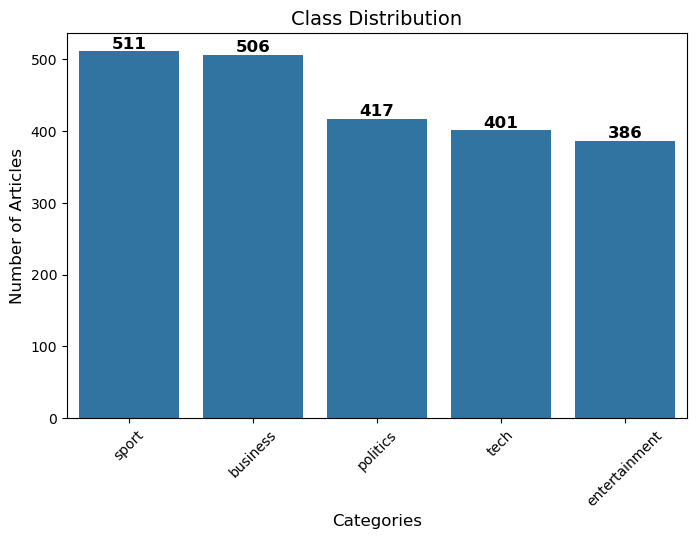

In [18]:
# Визуализация распределения классов
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)
plt.title('Class Distribution', fontsize=14)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.show()

Видим, что классы распределены не совсем равномерно. Постараемся это учесть при обучении.

Соберем методы в класс, унаследованный от torch.utils.data.Dataset, для загрузки и предварительной обработки данных.

In [19]:
class Dataset_Loader(Dataset):
    """
    A custom PyTorch Dataset class to load and preprocess text data from a zip-file.
    
    The dataset is expected to be organized into subfolders by category (e.g., 'sport', 'business', etc.).
    Each subfolder contains text files corresponding to news articles. This class handles extraction,
    reading, and prepares structured samples for model training or evaluation.
    """

    def __init__(self, zip_path):
        """
        Initializes the dataset by extracting the zip archive, discovering categories, 
        preprocessing all text files.

        Args:
            zip_path (str): Path to the zip file containing the dataset.
        """
        self.zip_path = zip_path

        # Temporary directory for extraction
        self.temp_dir = tempfile.TemporaryDirectory()
        self.extracted_path = self.temp_dir.name

        # Extract archive
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            zip_ref.extractall(self.extracted_path)

        # Try to detect the root directory containing class folders
        top_level_items = os.listdir(self.extracted_path)

        if len(top_level_items) == 1 and os.path.isdir(os.path.join(self.extracted_path, top_level_items[0])):
            # Case: archive has a single root folder (e.g. bbc/)
            self.folder_path = os.path.join(self.extracted_path, top_level_items[0])
        else:
            # Case: archive has class folders directly in root
            self.folder_path = self.extracted_path

        # Discover category folders
        self.categories = sorted([
            d for d in os.listdir(self.folder_path)
            if os.path.isdir(os.path.join(self.folder_path, d))
        ])
        self.label_map = {category: idx for idx, category in enumerate(self.categories)}

        # Collect and preprocess all samples
        self.samples = []
        for category in self.categories:
            folder = os.path.join(self.folder_path, category)
            for filename in os.listdir(folder):
                if filename.endswith(".txt"):
                    filepath = os.path.join(folder, filename)
                    with open(filepath, 'r', encoding='latin1', errors='replace') as f:
                        original_text = f.read()
                    processed_text = self.preprocess_text(original_text)
                    self.samples.append({
                        'article': original_text,
                        'text': processed_text,
                        'category': category,
                        'label': self.label_map[category]
                    })

    def preprocess_text(self, text):
        """
        Preprocesses the input text:
        - Decodes from latin1 to utf-8, ignoring invalid characters.
        - Converts text to lowercase.
        - Removes stop words, named entities, non-alphabetic tokens, short tokens.
        - Applies lemmatization.
        - Removes punctuation and extra whitespace.

        Args:
            text (str): The original input text.

        Returns:
            str: Cleaned and lemmatized text.
        """
        # Fix encoding issues
        text = text.encode("latin1").decode("utf-8", "ignore")

        # Process the text using spaCy
        doc = nlp(text)
        tokens = []

        for token in doc:
            # Keep tokens that are not stop words, not named entities,
            # alphabetic, and longer than 1 character
            if not token.is_stop and token.is_alpha and not token.ent_type_ and len(token) > 1:
                tokens.append(token.lemma_)

        # Join lemmatized tokens
        cleaned_text = " ".join(tokens)

        # Remove punctuation
        cleaned_text = cleaned_text.translate(str.maketrans("", "", string.punctuation))

        # Remove excess whitespace
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

        return cleaned_text.lower()

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns a single sample from the dataset by index.

        Args:
            idx (int): Index of the sample.

        Returns:
            dict: A dictionary with the following keys:
                - 'article': original text
                - 'text': preprocessed text
                - 'category': category name (e.g., 'sport')
                - 'label': integer class label
        """
        return self.samples[idx]

    def __del__(self):
        """
        Cleans up the temporary extraction directory upon deletion.
        """
        if hasattr(self, "temp_dir"):
            self.temp_dir.cleanup()

In [20]:
dataset = Dataset_Loader("bbc.zip")
print(len(dataset))

2221


In [21]:
pd.DataFrame([dataset.samples[0]])

article  \
0  UK economy facing 'major risks'\n\nThe UK manu...   

                                                text  category  label  
0  economy face major risk manufacturing sector c...  business      0

In [22]:
dataset.categories

['business', 'entertainment', 'politics', 'sport', 'tech']

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> SVM.</h4>
</div>

Разделим выборку на обучающую и тестовую.

In [23]:
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [24]:
X_train = [train_dataset[i]['text'] for i in range(len(train_dataset))]
y_train = [train_dataset[i]['category'] for i in range(len(train_dataset))]

X_test = [test_dataset[i]['text'] for i in range(len(test_dataset))]
y_test = [test_dataset[i]['category'] for i in range(len(test_dataset))]

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Подбор гиперпараметров.</h4>
</div>

Используем TF-IDF векторизацию для преобразования текста в числовой формат и выбираем SVM из классических алгоритмов.

In [25]:
# TF-IDF векторизация и SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(probability=True, class_weight='balanced'))
])

In [26]:
# Сетка гиперпараметров
param_grid = {
    # Подбор параметров для TF-IDF
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # униграммы, биграммы, триграммы
    'tfidf__min_df': [1, 3, 4, 5],  # Минимальная частота слова

    # Подбор параметров для SVM
    'svm__C': [0.1, 1, 10],  # Коэффициент регуляризации
}

In [27]:
# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'tfidf__min_df': [1, 3, 4, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [28]:
print('Best params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Лучшие параметры: {'svm__C': 1, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Лучшая точность: 0.9718499762620668


In [29]:
best_params = grid_search.best_params_
vect_params = {k.replace('tfidf__', ''): v for k, v in best_params.items() if k.startswith('tfidf__')}
svc_params = {k.replace('svc__', ''): v for k, v in best_params.items() if k.startswith('svc__')}

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Обучение модели.</h4>
</div>

Напишем класс для классификации с SVM моделью и TF-IDF векторизацией.

In [30]:
class SVMTextClassifier:
    """
    A text classification pipeline using SVM and TF-IDF vectorization.
    Supports training, evaluation, class prediction, and probability estimation.
    """

    def __init__(self, vectorizer_params=None, model_params=None):
        """
        Initialize the classifier.

        Args:
            vectorizer_params (dict): Parameters for TfidfVectorizer.
            model_params (dict): Parameters for sklearn SVC.
        """
        self.vectorizer = TfidfVectorizer(**(vectorizer_params or {}))
        self.model = SVC(**(model_params or {}), probability=True, class_weight='balanced')
        self.is_fitted = False

    def prepare_data(self, dataset: Dataset):
        """
        Extract text and label data from the dataset.

        Args:
            dataset (Dataset): Dataset returning a dict with 'text' and 'label'.

        Returns:
            tuple: (texts, labels)
        """
        texts = []
        labels = []
        for i in range(len(dataset)):
            sample = dataset[i]
            texts.append(sample['text'])
            labels.append(sample['label'])
        return texts, labels

    def plot_confusion_matrix(self, dataset: Dataset, label_names=None):
        """
        Plot the confusion matrix for predictions on the given dataset.
    
        Args:
            dataset (Dataset): Dataset with 'text' and 'label'.
            label_names (list of str): Class names for axis ticks.
        """
        texts, labels = self.prepare_data(dataset)
        preds = self.predict(dataset)
        self.cm = confusion_matrix(labels, preds)
    
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
    
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    def train(self, dataset: Dataset):
        """
        Train the model on the given dataset.

        Args:
            dataset (Dataset): Dataset with 'text' and 'label'.
        """
        texts, labels = self.prepare_data(dataset)
        X = self.vectorizer.fit_transform(texts)
        self.model.fit(X, labels)
        self.is_fitted = True
        print("Model trained successfully.")

    def predict(self, dataset: Dataset):
        """
        Predict class labels for a Dataset.
    
        Args:
            dataset (Dataset): Dataset.
    
        Returns:
            list: Predicted class labels.
        """
        texts = [sample['text'] for sample in dataset]
        X = self.vectorizer.transform(texts)
        return self.model.predict(X)

    def predict_proba(self, dataset: Dataset):
        """
        Predict class probabilities for a Dataset.
    
        Args:
            dataset (Dataset): Dataset.
    
        Returns:
            ndarray: Array of shape (n_samples, n_classes) with class probabilities.
        """
        texts = [sample['text'] for sample in dataset]
        X = self.vectorizer.transform(texts)
        return self.model.predict_proba(X)

    def evaluate(self, dataset: Dataset):
        """
        Evaluate model accuracy and print classification report.
    
        Args:
            dataset (Dataset): Dataset with 'text' and 'label'.
    
        Returns:
            float: Accuracy score.
        """
        texts, labels = self.prepare_data(dataset)
        preds = self.predict(dataset)  
        acc = accuracy_score(labels, preds)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(labels, preds, digits=4))
        return acc

In [31]:
clf = SVMTextClassifier(vectorizer_params=vect_params, model_params=svc_params)
clf.train(train_dataset)

Model trained successfully.


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Оценка качества модели.</h4>
</div>

In [32]:
clf.evaluate(test_dataset)

Accuracy: 0.9640
Classification Report:
              precision    recall  f1-score   support

           0     0.9619    0.9182    0.9395       110
           1     0.9855    0.9714    0.9784        70
           2     0.8876    0.9634    0.9240        82
           3     1.0000    1.0000    1.0000        94
           4     0.9886    0.9775    0.9831        89

    accuracy                         0.9640       445
   macro avg     0.9647    0.9661    0.9650       445
weighted avg     0.9653    0.9640    0.9643       445



0.9640449438202248

###### Выводы по метрикам:
 - <b>Accuracy</b> = 96.4% значит, что SVM модель почти безошибочно классифицирует статьи - это высокая общая точность.
 - <b>business</b> recall < precision, значит модель точно угадывает те примеры, которые относит к классу, но пропускает некоторые настоящие примеры этого класса.
 - <b>entertainment</b> почти идеально. Высокая точность и полнота.
 - <b>politics</b> модель иногда путает с чем то другим.
 - <b>sport</b> идеальные метрики.
 - <b>tech</b> почти идеально. Высокая точность и полнота.

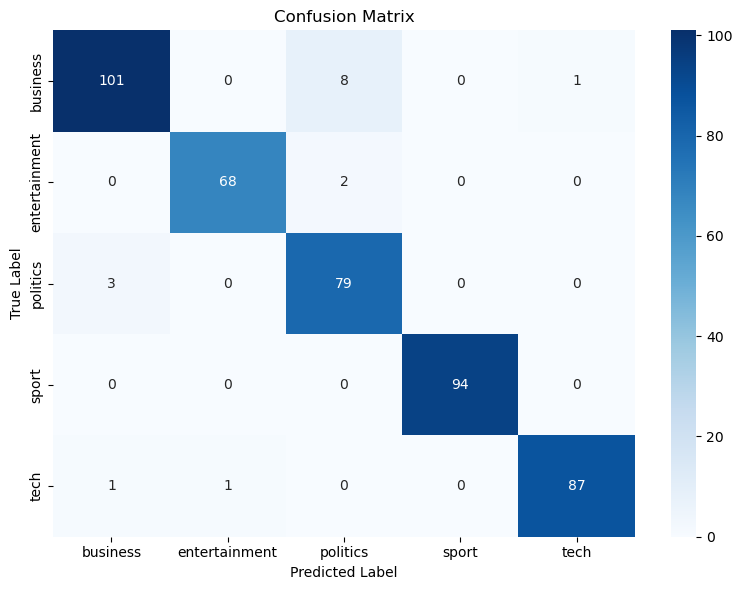

In [33]:
#Построим Confusion Matrix
clf.plot_confusion_matrix(test_dataset, label_names=dataset.categories)

#### Вывод по матрице ошибок:
 - business ошибки:
	•	8 предсказано как politics,
	•	1 предсказано как tech,
	 - Вывод: модель немного путает бизнес с политикой и технологиями, но это могут быть статьи на тему государственных программ или заказов.
 -  entertainment ошибки:
	•	2 предсказано как politics
	 - Вывод: Забавно, что развлечения перепутались с политикой).
 - politics
	•	3 предсказано как business
	•	Вывод: Возможно политические статьи могут касаться экономики.
 - sport
	•	94/94 - идеально
	 - Вывод: этот класс очень четко классифицирован.
 - tech
	•	1 предсказано как business,
	•	1 как entertainment
	 - Вывод: возможно, статьи о потребительской электронике могут ошибочно определяться.

#### Общий вывод:
- Модель SVM показывает отличные результаты и почти не допускает ошибок.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Дообучение модели DistillBert для многоклассовой классификации.</h4>
</div>

Напишем класс дообучения модели DistillBert.

In [34]:
class DistilBertTextClassifier:
    """
    A DistilBERT-based classifier for multiclass text classification.
    Uses raw article text from Dataset_Loader 
    """

    def __init__(self, model_name='distilbert-base-uncased', num_labels=5, lr=2e-5, batch_size=8, max_length=512):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.model.to(self.device)

        self.lr = lr
        self.batch_size = batch_size
        self.max_length = max_length
        self.is_fitted = False

    def encode_dataset(self, dataset):
        """
        Tokenizes and encodes the dataset using the raw 'article' field.

        Args:
            dataset (Dataset): Dataset_Loader instance.

        Returns:
            tuple: (input_ids, attention_mask, labels) as torch tensors.
        """
        texts = [sample['article'] for sample in dataset]
        labels = [sample['label'] for sample in dataset]

        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels)

    def plot_confusion_matrix(self, dataset, label_names=None, normalize=False):
        """
        Plot the confusion matrix for predictions on the given dataset.
    
        Args:
            dataset (Dataset): Dataset with 'article' and 'label'.
            label_names (list of str, optional): List of class names to display on axes.
            normalize (bool): If True, normalize the matrix row-wise.
        """
        true_labels = [sample['label'] for sample in dataset]
        preds = self.predict(dataset)
    
        self.cm = confusion_matrix(true_labels, preds)
    
    
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
    
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def train(self, dataset, epochs=3):
        """
        Fine-tunes the model on the given dataset using torch.optim.Adam instead of AdamW.
    
        Args:
            dataset (Dataset): Training dataset.
            epochs (int): Number of training epochs.
        """
        input_ids, attention_mask, labels = self.encode_dataset(dataset)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
        self.model.train()
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            for start in range(0, len(labels), self.batch_size):
                end = start + self.batch_size
    
                input_batch = input_ids[start:end].to(self.device)
                mask_batch = attention_mask[start:end].to(self.device)
                label_batch = labels[start:end].to(self.device)
    
                outputs = self.model(input_ids=input_batch, attention_mask=mask_batch, labels=label_batch)
                loss = outputs.loss
                loss.backward()
    
                optimizer.step()
                optimizer.zero_grad()
    
                if not (start // self.batch_size) % 100:
                    print(f"Batch {start // self.batch_size + 1}: loss = {loss.item():.4f}")
    
        self.is_fitted = True
        print("Training complete.")

    def predict(self, dataset):
        """
        Predicts class labels for the given dataset.

        Args:
            dataset (Dataset): Dataset for predict.

        Returns:
            list: Predicted class labels.
        """
        input_ids, attention_mask, _ = self.encode_dataset(dataset)

        self.model.eval()
        with torch.no_grad():
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().tolist()

        return preds

    def predict_proba(self, dataset):
        """
        Predicts class probabilities for the given dataset without using torch.nn.functional.
    
        Args:
            dataset (Dataset): Dataset for prediction.
    
        Returns:
            np.ndarray: Array of shape (n_samples, n_classes) with probabilities.
        """
        input_ids, attention_mask, _ = self.encode_dataset(dataset)
    
        self.model.eval()
        with torch.no_grad():
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)
    
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
    
            # Apply softmax manually using numpy
            exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # for numerical stability
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
        return probs

    def evaluate(self, dataset):
        """
        Evaluates the model on the provided dataset.

        Args:
            dataset (Dataset): Dataset with ground-truth labels.

        Returns:
            float: Accuracy score.
        """
        true_labels = [sample['label'] for sample in dataset]
        preds = self.predict(dataset)

        acc = accuracy_score(true_labels, preds)
        print(f"\nAccuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(true_labels, preds, digits=4))
        return acc

In [35]:
clf2 = DistilBertTextClassifier(num_labels=5)
clf2.train(train_dataset, epochs=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Batch 1: loss = 1.6026
Batch 101: loss = 0.1945
Batch 201: loss = 0.0461

Epoch 2/3
Batch 1: loss = 0.3188
Batch 101: loss = 0.0241
Batch 201: loss = 0.0124

Epoch 3/3
Batch 1: loss = 0.0123
Batch 101: loss = 0.0112
Batch 201: loss = 0.0091
Training complete.


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Оценка качества модели DistillBert.</h4>
</div>

In [36]:
clf2.evaluate(test_dataset)


Accuracy: 0.9775
Classification Report:
              precision    recall  f1-score   support

           0     0.9720    0.9455    0.9585       110
           1     1.0000    0.9857    0.9928        70
           2     0.9310    0.9878    0.9586        82
           3     1.0000    1.0000    1.0000        94
           4     0.9886    0.9775    0.9831        89

    accuracy                         0.9775       445
   macro avg     0.9783    0.9793    0.9786       445
weighted avg     0.9781    0.9775    0.9776       445



0.9775280898876404

#### Выводы по метрикам:
 - <b>Accuracy</b> = 97,75% значит, что модель почти безошибочно классифицирует статьи - это высокая общая точность, что лучше чем SVM.
 - <b>business</b> несколько новостей были ошибочно классифицированы в другую категорию.
 - <b>entertainment</b> почти идеальные метрики, но несколько новостей были ошибочно классифицированы в другую категорию.
 - <b>politics</b> все политические статьи правильно классифицированы, но несколько лишних статей попало в политику.
 - <b>sport</b> идеальные метрики.
 - <b>tech</b> почти идеальные метрики, но несколько новостей были ошибочно классифицированы в другую категорию.

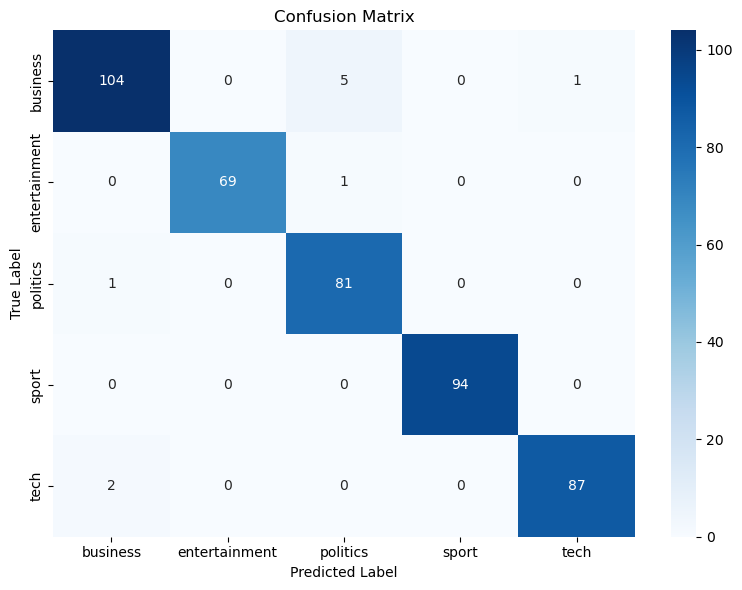

In [37]:
clf2.plot_confusion_matrix(test_dataset, label_names=dataset.categories)

#### Вывод:
 - business ошибки: 5 предсказано как politics, 1 предсказано как tech
	 - Вывод: как и ранее, бизнес немного путается с политикой и технологиями — вполне логично, границы могут быть размыты.
 - entertainment ошибки: 1 предсказано как politics
	 - Вывод: Возможно, статья касалась политических аспектов развлечений или развлечений политиков.
 - politics
	 - Вывод: Модель безошибочно определяет политические статьи.
 - sport
	 - Вывод: Модель безошибочно определяет спортивные статьи.
 - tech
	 - Вывод: 2 предсказано как business.

<div style="background-color: powderblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Сбор свежих статей.</h4>
</div>

Выберем по пять свежих статей на каждую из тем.

In [38]:
entertainment = [
    'https://www.bbc.com/news/articles/c4g007jjlyqo',
    'https://www.bbc.com/news/articles/cgkmmkyrl0vo',
    'https://www.bbc.com/news/articles/cqjd051z5ejo',
    'https://www.bbc.com/culture/article/20250227-10-of-the-best-films-to-watch-this-march',
    'https://www.bbc.com/culture/article/20250228-oscars-2025-who-will-win-and-who-should'
]

In [39]:
business = [
    'https://www.bbc.com/news/articles/cedll3282qzo',
    'https://www.bbc.com/news/articles/clydd7zeye7o', 
    'https://www.bbc.com/news/articles/ce8yy3wpn6eo',
    'https://www.bbc.com/news/articles/c4g7xn9y64po',
    'https://www.bbc.com/news/articles/ce980m2xv30o'
]

In [40]:
tech = [
    'https://www.bbc.com/news/articles/c5y0r8wdk62o',
    'https://www.bbc.com/news/articles/cn7vxlrvxyeo',
    'https://www.bbc.com/news/articles/cy877gydn48o',
    'https://www.bbc.com/future/article/20250228-5-youtube-videos-that-changed-the-way-we-think-about-ourselves',
    'https://www.bbc.com/news/articles/cgm18g19013o'
]

In [41]:
sport = [
    'https://www.bbc.com/sport/football/articles/c70w5q4kzkvo',
    'https://www.bbc.com/sport/football/articles/cjry7dj9v2po',
    'https://www.bbc.com/sport/football/articles/c9dej12zezno',
    'https://www.bbc.com/sport/athletics/articles/c3rn8qq2elxo',
    'https://www.bbc.com/sport/golf/articles/ce8vje3ldypo'
]

In [42]:
politics = [
    'https://www.bbc.com/news/articles/c7988r3q1p2o',
    'https://www.bbc.com/news/articles/cpv44982jlgo',
    'https://www.bbc.com/news/articles/cn9v1lzwqn7o',
    'https://www.bbc.com/news/articles/c981lr84013o',
    'https://www.bbc.com/news/articles/crmj298x7ypo'
]

In [43]:
bbc_val = {
    'entertainment': entertainment,
    'business': business,
    'tech': tech,
    'sport': sport,
    'politics': politics
}

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Сохранение новых статей.</h4>
</div>

In [ ]:
Напишем метод для удобства, который сохранит новость по заданной ссылке.

In [44]:
def save_article_text(url, filename):
        """Fetches the main content and title of a news article from a given URL and saves them to a .txt file.
        Params:
            url: str
                Article url
            filename: str
                Path to save text
        """
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Находим и читаем заголовок
            title = soup.find('h1')
            title_text = title.get_text().strip() if title else ''
            
            # Читаем статью
            article_body = soup.find('article')
            if article_body:
                paragraphs = article_body.find_all('p')
                article_text = '\n'.join([p.get_text() for p in paragraphs])
                
                # Сохраняем
                with open(filename, 'w', encoding='utf-8') as file:
                    file.write(title_text)
                    file.write(article_text)
                print(f"Article saved successfully to {filename}")
            else:
                print("Fail.")
        else:
            print("Fail.")

In [45]:
# Сохраним в папку с аналогичной структурой с исходным данным
for key in bbc_val.keys():
    os.makedirs(f'validation/{key}', exist_ok=True)
    for i in range(0, len(bbc_val[key])):
        save_article_text( url = bbc_val[key][i], filename = f'validation/{key}/{i}.txt')

Article saved successfully to validation/entertainment/0.txt
Article saved successfully to validation/entertainment/1.txt
Article saved successfully to validation/entertainment/2.txt
Article saved successfully to validation/entertainment/3.txt
Article saved successfully to validation/entertainment/4.txt
Article saved successfully to validation/business/0.txt
Article saved successfully to validation/business/1.txt
Article saved successfully to validation/business/2.txt
Article saved successfully to validation/business/3.txt
Article saved successfully to validation/business/4.txt
Article saved successfully to validation/tech/0.txt
Article saved successfully to validation/tech/1.txt
Article saved successfully to validation/tech/2.txt
Article saved successfully to validation/tech/3.txt
Article saved successfully to validation/tech/4.txt
Article saved successfully to validation/sport/0.txt
Article saved successfully to validation/sport/1.txt
Article saved successfully to validation/sport/2.

У нас теперь есть папка с сохраненными новостями, заархивируем ее.

In [46]:
def zip_folder(folder_path, output_zip_path):
    """
    Create a ZIP archive from the contents of a folder.

    Args:
        folder_path (str): Path to the folder to zip.
        output_zip_path (str): Path to the output .zip file.
    """
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # сохраняем относительный путь внутри архива
                arcname = os.path.relpath(file_path, start=folder_path)
                zipf.write(file_path, arcname)
    print(f"Folder '{folder_path}' zipped successfully to '{output_zip_path}'.")

In [47]:
zip_folder('validation', 'validation.zip')

Folder 'validation' zipped successfully to 'validation.zip'.


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> SVM и свежие новости.</h4>
</div>

Загрузим свежие новости в dataset

In [48]:
dataset_new = Dataset_Loader('validation.zip')
print(len(dataset_new))

25


Посмотрим что все в порядке

In [49]:
pd.DataFrame([dataset_new.samples[0]])

article  \
0  Apple commits to $500bn US investmentApple pla...   

                                                text  category  label  
0  commit investmentapple plan invest start new a...  business      0

In [50]:
dataset_new.categories

['business', 'entertainment', 'politics', 'sport', 'tech']

Проверим как классифицирует уже обученныя SVM новые данные

In [51]:
preds = clf.predict(dataset_new)
probs = clf.predict_proba(dataset_new)

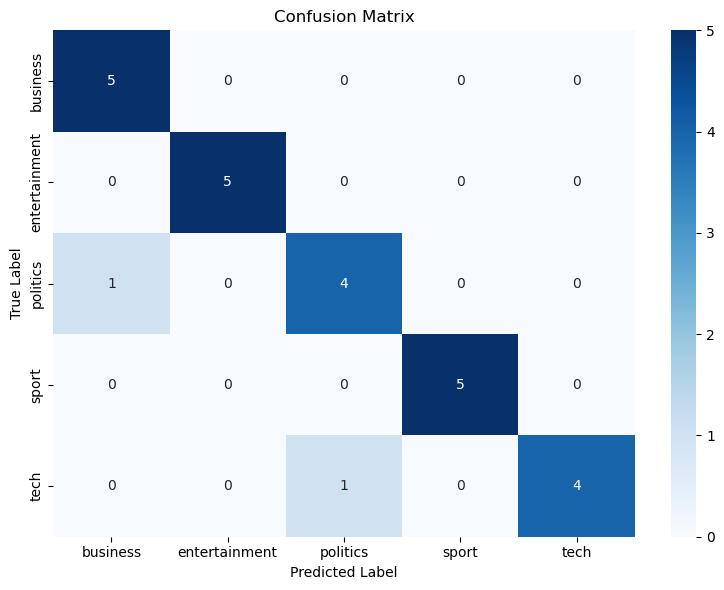

In [52]:
#Построим Confusion Matrix
clf.plot_confusion_matrix(dataset_new, label_names=dataset.categories)

#### Вывод:
SVM справилась хорошо, но допустила пару ошибок:
 -  politics: 1 ошибка - предсказано как business.
 -  tech: 1 ошибка - предсказано как politics.

In [53]:
# рассмотрим предсказания подробне
true_labels = [sample["label"] for sample in dataset_new]
label_names = dataset.categories
articles = [sample["article"] for sample in dataset_new]

In [54]:
# для удобства поместим все в pd.DataFrame
df = pd.DataFrame(probs, columns=[f"proba_{cls}" for cls in label_names])
df["true_label"] = [label_names[i] for i in true_labels]
df["predicted_label"] = [label_names[i] for i in preds]
df["article"] = articles  

In [55]:
df

proba_business  proba_entertainment  proba_politics   proba_sport  \
0     9.980123e-01         1.104656e-04    5.978574e-04  7.056940e-05   
1     9.939666e-01         1.883342e-04    3.305988e-03  2.196950e-04   
2     9.539991e-01         2.312984e-03    3.859920e-02  3.241092e-03   
3     9.594468e-01         5.762179e-04    1.105562e-02  8.159388e-04   
4     7.071163e-01         4.202171e-02    1.576473e-01  1.773274e-02   
5     1.166068e-10         9.999809e-01    3.772724e-08  1.071131e-05   
6     1.294901e-07         9.994540e-01    2.648710e-06  2.390158e-05   
7     3.980948e-08         9.996934e-01    4.183285e-06  1.851986e-04   
8     1.150140e-10         9.999901e-01    9.895794e-08  1.186544e-06   
9     1.408338e-03         7.893100e-01    4.815547e-03  4.769380e-03   
10    3.400423e-01         1.272908e-02    6.393213e-01  2.248849e-03   
11    6.264554e-03         1.122963e-04    9.930172e-01  4.488335e-04   
12    2.071481e-02         1.310670e-03    9.741131e-01  1.156788e-03   
13    7.409885e-01         2.676271e-03    2.489214e-01  6.015570e-03   
14    3.769816e-03         1.659698e-05    9.961328e-01  5.895642e-05   
15    1.087401e-03         1.711587e-03    2.873990e-03  9.881288e-01   
16    7.798573e-07         1.334595e-06    7.437979e-07  9.996668e-01   
17    1.500599e-08         2.114324e-08    1.180622e-08  9.999713e-01   
18    1.305716e-09         1.816775e-09    1.111137e-09  9.999611e-01   
19    3.299120e-03         1.467097e-03    4.713694e-03  9.877728e-01   
20    2.182158e-01         1.375332e-01    3.089961e-01  2.465842e-02   
21    1.254059e-04         2.527487e-03    4.658232e-04  6.352981e-05   
22    1.929309e-07         2.665910e-07    1.585451e-07  3.199564e-07   
23    2.857524e-02         4.134069e-03    1.051891e-02  6.752332e-03   
24    8.801540e-07         4.855206e-07    5.677807e-07  2.926606e-07   

    proba_tech     true_label predicted_label  \
0     0.001209       business        business   
1     0.002319       business        business   
2     0.001848       business        business   
3     0.028105       business        business   
4     0.075482       business        business   
5     0.000008  entertainment   entertainment   
6     0.000519  entertainment   entertainment   
7     0.000117  entertainment   entertainment   
8     0.000009  entertainment   entertainment   
9     0.199697  entertainment   entertainment   
10    0.005658       politics        politics   
11    0.000157       politics        politics   
12    0.002705       politics        politics   
13    0.001398       politics        business   
14    0.000022       politics        politics   
15    0.006198          sport           sport   
16    0.000330          sport           sport   
17    0.000029          sport           sport   
18    0.000039          sport           sport   
19    0.002747          sport           sport   
20    0.310596           tech        politics   
21    0.996818           tech            tech   
22    0.999999           tech            tech   
23    0.950019           tech            tech   
24    0.999998           tech            tech   

                                              article  
0   Apple commits to $500bn US investmentApple pla...  
1   Major Asia bank to cut 4,000 roles as AI repla...  
2   Trump says US will impose additional 10% tarif...  
3   Faisal Islam: Any Starmer deal with Trump is a...  
4   US judge says mass firings of some federal wor...  
5   Oscars 2025 predictions: Who will win - and wh...  
6   Disney's Snow White to Mickey 17: 10 of the be...  
7   'I didn't want to be in a bad stripper film': ...  
8   Brit Awards: Five things to look out for in to...  
9   Has Shrek had a face lift? Trailer for new fil...  
10  States members pay to see slight increaseState...  
11  UK may have to leave human rights treaty, says...  
12  Ex-Tory MP to lead review of Islamophobia defi...  
13  UK-US trade deal could mean tariffs 'not n

In [ ]:
Посмотрим на новсти, в которых модель ошиблась подробнее:

In [56]:
df.article[13]

'UK-US trade deal could mean tariffs \'not necessary\', says TrumpA trade deal between the US and UK could happen "very quickly", President Donald Trump said at a joint press conference with Sir Keir Starmer.\nSpeaking during the prime minister\'s visit to the White House, Trump envisaged "a real trade deal" which could see the UK avoid the kind of tariffs the president has been threatening on some of the US\'s other trading partners. \nThe trip had been seen as a key moment in Sir Keir\'s premiership as he sought to influence Trump\'s decisions on topics including Ukraine, as well as trade. \nSir Keir kicked off his White House visit by presenting Trump with a letter from King Charles inviting him to an "unprecedented" second state visit to the UK.  \nReceiving the letter in front of cameras in the Oval Office, Trump said it would be a "great honour" and described the King as "a wonderful man".\nSir Keir said the offer of a second state visit was "truly historic". Traditionally US pre

In [57]:
df.article[20]

'\'I\'m not tech-savvy - but within hours I could buy an illegal knife on social media\'I\'m 48, use social media occasionally, and I\'m not very tech-savvy. Until recently I\'d never used Telegram.\nBut last year, after meeting the family of Ronan Kanda - the 16-year-old who was killed in a case of mistaken identity by two other teenagers who\'d bought a sword and machete online - I decided to figure out how easy it was to buy a knife from social media.\nIt seemed like the children in the case were able to buy huge, deadly weapons with shocking ease.\nSo in spring 2024, I set up several social media accounts in the name of a fake 18-year-old man. He is a Londoner who is friends with a group of young men who carry knives. He thinks he needs one too, to protect himself, and he knows larger knives are more intimidating.\nI got myself a separate mobile so my new searches would not impact my usual browsing algorithms. I started searching for knives, liking and following accounts which offe

#### Вывод:
SVM справилась хорошо, но допустила пару ошибок:
 -  politics: 1 ошибка - предсказано как business. 74.09%, что это business, politics — вторая по вероятности (24.89%). Как видим в политической статье действительно много слов связанных с бизнесом и торговлей.
 -  tech: 1 ошибка - предсказано как politics. Вероятности tech и politics очень близки: tech - 31.05%, politics - 30.89%. В статье упоминается много слов про законы и регулирование, безопасность, государственные инициативы.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> DistilBERT.</h4>
</div>

Проверим как стравится DistilBERT на новых данных.

In [58]:
preds = clf2.predict(dataset_new)

In [59]:
probs = clf2.predict_proba(dataset_new)

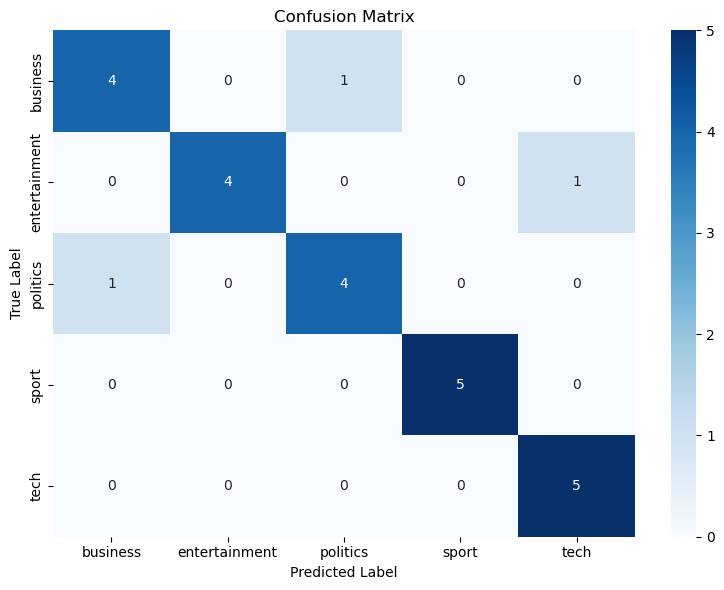

In [60]:
clf2.plot_confusion_matrix(dataset_new,  label_names=dataset_new.categories)

In [61]:
# рассмотрим предсказания подробне
true_labels = [sample["label"] for sample in dataset_new]
label_names = dataset.categories
articles = [sample["article"] for sample in dataset_new]

In [62]:
# для удобства поместим все в pd.DataFrame
df = pd.DataFrame(probs, columns=[f"proba_{cls}" for cls in label_names])
df["true_label"] = [label_names[i] for i in true_labels]
df["predicted_label"] = [label_names[i] for i in preds]
df["article"] = articles  

In [63]:
df

proba_business  proba_entertainment  proba_politics  proba_sport  \
0         0.987713             0.001271        0.001252     0.001508   
1         0.983025             0.001438        0.001556     0.001783   
2         0.992750             0.001420        0.002636     0.001553   
3         0.984453             0.001515        0.001312     0.001579   
4         0.324139             0.017766        0.642799     0.006575   
5         0.001341             0.995206        0.001236     0.001022   
6         0.001262             0.995397        0.001110     0.000791   
7         0.001257             0.995254        0.001258     0.000999   
8         0.001409             0.995224        0.001213     0.000982   
9         0.006244             0.098579        0.003985     0.002496   
10        0.017376             0.002665        0.975809     0.002305   
11        0.009092             0.001577        0.986446     0.001608   
12        0.003301             0.001402        0.992975     0.001193   
13        0.773257             0.005544        0.209831     0.006956   
14        0.004849             0.001278        0.991457     0.001339   
15        0.003522             0.001074        0.001676     0.992239   
16        0.001875             0.001098        0.001056     0.994891   
17        0.003085             0.001609        0.000937     0.993052   
18        0.001423             0.000771        0.000726     0.996348   
19        0.003866             0.001060        0.001143     0.992854   
20        0.004130             0.002110        0.001560     0.001122   
21        0.002945             0.002502        0.001392     0.000990   
22        0.003483             0.003214        0.001538     0.001229   
23        0.004806             0.002104        0.001477     0.001100   
24        0.002980             0.002017        0.001386     0.001012   

    proba_tech     true_label predicted_label  \
0     0.008255       business        business   
1     0.012197       business        business   
2     0.001641       business        business   
3     0.011141       business        business   
4     0.008721       business        politics   
5     0.001195  entertainment   entertainment   
6     0.001440  entertainment   entertainment   
7     0.001232  entertainment   entertainment   
8     0.001172  entertainment   entertainment   
9     0.888695  entertainment            tech   
10    0.001845       politics        politics   
11    0.001277       politics        politics   
12    0.001129       politics        politics   
13    0.004412       politics        business   
14    0.001076       politics        politics   
15    0.001488          sport           sport   
16    0.001080          sport           sport   
17    0.001317          sport           sport   
18    0.000733          sport           sport   
19    0.001077          sport           sport   
20    0.991078           tech            tech   
21    0.992171           tech            tech   
22    0.990536           tech            tech   
23    0.990513           tech            tech   
24    0.992606           tech            tech   

                                              article  
0   Apple commits to $500bn US investmentApple pla...  
1   Major Asia bank to cut 4,000 roles as AI repla...  
2   Trump says US will impose additional 10% tarif...  
3   Faisal Islam: Any Starmer deal with Trump is a...  
4   US judge says mass firings of some federal wor...  
5   Oscars 2025 predictions: Who will win - and wh...  
6   Disney's Snow White to Mickey 17: 10 of the be...  
7   'I didn't want to be in a bad stripper film': ...  
8   Brit Awards: Five things to look out for in to...  
9   Has Shrek had a face lift? Trailer for new fil...  
10  States members pay to see slight increaseState...  
11  UK may have to leave human rights treaty, says...  
12  Ex-Tory MP to lead review of Islamophobia defi...  
13  UK-US trade deal could mean tariffs 'not neces...  
14  Minister Ann

Посмотрим на неверно классифицированные новости подробнее:

In [64]:
df.article[9]

'Has Shrek had a face lift? Trailer for new film divides fansThe long-awaited first trailer for the new Shrek 5 film has been criticised by some film fans over the way characters have been animated, giving them different facial features.\nIn the 27-second clip, recurring characters Shrek, Donkey, Pinocchio and Princess Fiona appear alongside Felicia - one of Shrek and Fiona\'s now grown-up children. \nThe short teaser announces that Zendaya is joining the cast as Felicia, whilst also reintroducing Mike Myers, Cameron Diaz and Eddie Murphy who are all reprising their roles.\nOli Hyatt, who runs Blue Zoo Animation, told the BBC there\'s often "an instant reaction" when changes are made to a film like Shrek, due to its "nostalgic properties".\n\nSome users on social media have described the changes as "disrespectful to the original art style" and "an AI interpretation of what Shrek 5 could look like".\nOthers have compared it to the film animation of video game character Sonic the Hedgeho

In [65]:
df.article[4]

'US judge says mass firings of some federal workers likely illegalA California judge has said the mass firings of probationary employees by the Trump administration were likely unlawful. \nThe ruling said the Office of Personnel Management (OPM) had told thousands of employees across a handful of federal agencies they were fired using authority the agency does not have, US District Judge William Alsup ruled.\n"[OPM] does not have any authority whatsoever, under any statute in the history of the universe, to hire and fire employees at another agency," he said. "They can hire and fire their own employees."\nIn court the government argued OPM asked, not ordered, the agencies to fire these employees. \nThey also argued that probationary employees are not guaranteed employment and that only the highest performing and mission-critical employees should be hired.\nGovernment workers have been the target of the Trump administration\'s efforts to reduce the federal workforce in the name of cutti

#### Вывод:
DistilBERT справился хорошо. Видим пару ошибок: 
 - business - 1 ошибочно отнесена к politics. business - 32.41%, politics - 64.27%. Речь в новости идет о судебном решении против администрации Трампа и массовых увольнениях, встречается много слов связанных с судами, властью и законами.
 - entertainment - 1 ошибочно отнесена к tech, entertainment - 9.85%, tech - 88.86%. Как видим в статье встречается много терминов, связанных с технологиями.

#### Общий вывод:
 - SVM и DistilBERT сделали по две ошибки на новых данных.
 - Метрики чуть лучше у DistilBERT, чем у SVM.
 - Но SVM работает быстрее.

### Задание 2:

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 

Оценка: 5 баллов


Рекомендации по выполнению домашнего задания:

 - Для формирования датасета, рекомендую пользоваться модулем datasets, который мы изучили на лекции. 

 - По поводу представления корпуса данных, выбираем любой удобный вам способ, который как вы считаете лучше всего решит вам задачу.

 - Реализовываем весь пайплайн от загрузки, очистки и NLP пайплайна до подачи данных в датасет, весь тот процесс который был продемонстрирован в первых лекциях. 


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Datasets.</h4>
</div>

Нужно смоделировать распределение тем по каждому из классов. Для этого напишем класс, который будет выделять данные по категории.

In [66]:
class SubsetByCategory(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [67]:
category_groups = {}
for sample in dataset:
    category = sample['category']
    if category not in category_groups:
        category_groups[category] = []
    category_groups[category].append(sample)

In [68]:
business_dataset = SubsetByCategory(category_groups['business'])
entertainment_dataset = SubsetByCategory(category_groups['entertainment'])
politics_dataset = SubsetByCategory(category_groups['politics'])
sport_dataset = SubsetByCategory(category_groups['sport'])
tech_dataset = SubsetByCategory(category_groups['tech'])

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Topic Modelling. Latent Dirichlet Allocation.</h4>
</div>

Напишем класс для topic modelling c LDA и BoW.

In [69]:
class LdaTopicModeling:
    """
    Perform LDA topic modeling on a dataset of preprocessed texts (from Dataset_Loader).
    """

    def __init__(self, dataset, passes=10):
        """
        Initialize the LDA model with preprocessed texts.

        Args:
            dataset (Dataset): Dataset_Loader instance.
            passes (int): Number of passes during training.
        """
        self.texts = [self.tokenize(sample['text']) for sample in dataset]
        self.passes = passes
        self.num_topics = None

        self.dictionary = corpora.Dictionary(self.texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in self.texts]
        self.lda_model = None

    def tokenize(self, text):
        """
        Tokenize text and remove stopwords.

        Args:
            text (str): Preprocessed text.

        Returns:
            list[str]: Cleaned list of tokens.
        """
        tokens = word_tokenize(text.lower())
        return [t for t in tokens if t.isalpha() and t not in stopwords.words("english")]

    def find_optimal_num_topics(self, min_topics=2, max_topics=10, step=1, topn=10, plot=True):
        """
        Try different numbers of topics, compute coherence score for each, and optionally plot.
    
        Args:
            min_topics (int): Minimum number of topics to try.
            max_topics (int): Maximum number of topics to try.
            step (int): Step size between topic counts.
            topn (int): Number of top words per topic for coherence.
            plot (bool): Show a matplotlib plot of coherence scores.
    
        Returns:
            num_topics (int)
        """
        scores = []
        topic_range = range(min_topics, max_topics + 1, step)
    
        for num in topic_range:
            model = LdaModel(
                corpus=self.corpus,
                id2word=self.dictionary,
                num_topics=num,
                passes=self.passes,
                random_state=42
            )
            coherence_model = CoherenceModel(model=model, texts=self.texts, dictionary=self.dictionary, coherence='c_v', topn=topn)
            score = coherence_model.get_coherence()
            scores.append((num, score))
    
        # Plot if requested
        if plot:
            x, y = zip(*scores)
            plt.figure(figsize=(8, 5))
            plt.plot(x, y, marker='o', linestyle='-', color='steelblue')
            plt.xlabel("Number of Topics")
            plt.ylabel("Coherence Score (c_v)")
            plt.title("Optimal Number of Topics by Coherence")
            plt.grid(True)
            plt.xticks(x)
            plt.tight_layout()
            plt.show()
    
        # Best suggestion
        best = max(scores, key=lambda x: x[1])
        print(f"Best number of topics: {best[0]} (coherence = {best[1]:.4f})")
        self.num_topics = best[0]
        return best[0]

    def train(self):
        """
        Train the LDA model.
        """
        
        self.lda_model = LdaModel(
            corpus=self.corpus,
            id2word=self.dictionary,
            num_topics=self.num_topics,
            passes=self.passes,
            random_state=42
        )
        print("Training complete.")

    def print_topics(self, num_words=10):
        """
        Print top words in each topic.

        Args:
            num_words (int): Number of words to display per topic.
        """
        topics = self.lda_model.show_topics(num_topics=self.num_topics, num_words=num_words, formatted=False)
        for idx, topic in topics:
            keywords = [word for word, _ in topic]
            print(f"Topic {idx}: {', '.join(keywords)}")

    def plot_topic_keywords(self, topic_id, num_words=10):
        """
        Plot side-by-side bar chart and word cloud of keywords for a topic.
    
        Args:
            topic_id (int): ID of the topic.
            num_words (int): Number of top keywords to show.
        """
        # Get keywords
        topic_terms = self.lda_model.show_topic(topic_id, topn=num_words)
        words, weights = zip(*topic_terms)
    
        # subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
        # Hist
        axes[0].barh(words[::-1], weights[::-1])
        axes[0].set_title(f"Topic {topic_id} — Top {num_words} Words (Weights)")
        axes[0].set_xlabel("Importance")
        axes[0].invert_yaxis()
    
        # Wordcloud
        word_freq = dict(topic_terms)
        wordcloud = WordCloud(width=400, height=300).generate_from_frequencies(word_freq)
    
        axes[1].imshow(wordcloud, interpolation='bilinear')
        axes[1].axis("off")
        axes[1].set_title(f"Topic {topic_id} — Word Cloud")
    
        plt.tight_layout()
        plt.show()

    def get_document_topics(self, idx):
        """
        Return topic distribution for a single document.

        Args:
            idx (int): Index of the document in the dataset.

        Returns:
            list[tuple[int, float]]: Topic ID and probability.
        """
        return self.lda_model.get_document_topics(self.corpus[idx])

In [70]:
def print_result(category_dataset):
    lda_model = LdaTopicModeling(category_dataset)
    num_topics = lda_model.find_optimal_num_topics(min_topics=2, max_topics=10, step=1, plot = True)
    lda_model.train()
    lda_model.print_topics(num_words=20)
    for i in range(0, num_topics):
        lda_model.plot_topic_keywords(topic_id=i, num_words=10)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Business. LDA</h4>
</div>

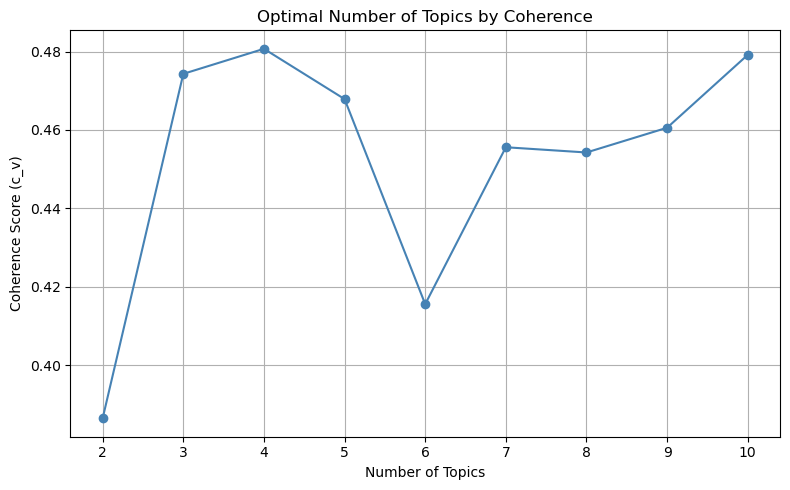

Best number of topics: 4 (coherence = 0.4807)
Training complete.
Topic 0: say, company, mr, firm, sale, government, profit, state, executive, chief, court, share, claim, pay, bank, oil, country, tax, business, new
Topic 1: say, firm, share, market, deal, company, mr, offer, bid, new, buy, business, sale, car, shareholder, big, takeover, report, stake, profit
Topic 2: say, economy, oil, dollar, economic, rise, growth, country, government, price, rate, high, market, deficit, mr, world, trade, report, expect, analyst
Topic 3: say, growth, rise, rate, economy, price, market, fall, economic, figure, high, cost, expect, country, interest, consumer, job, strong, increase, economist


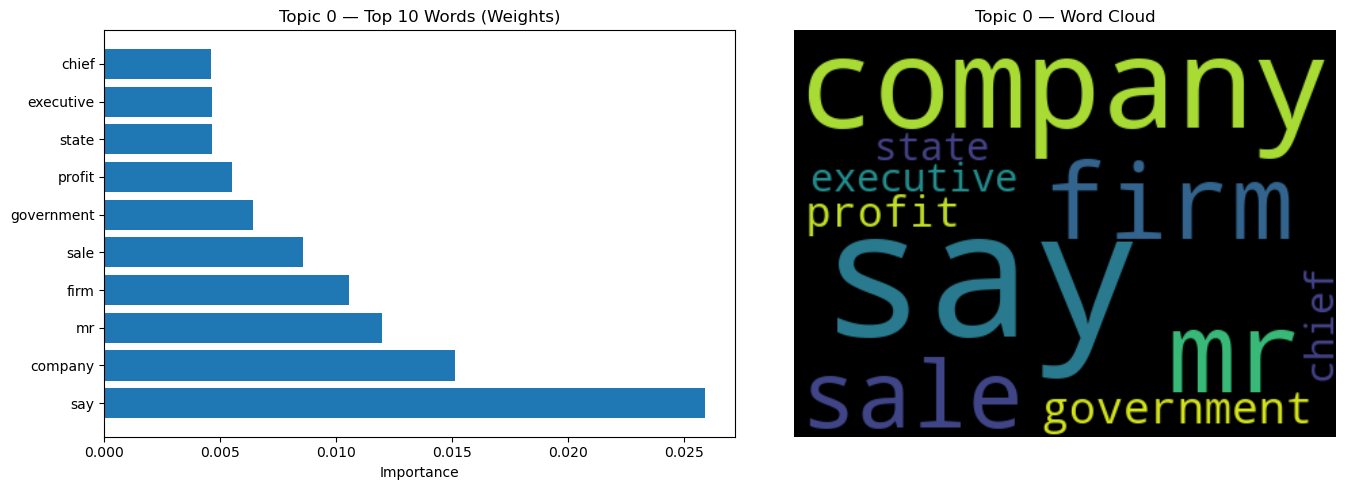

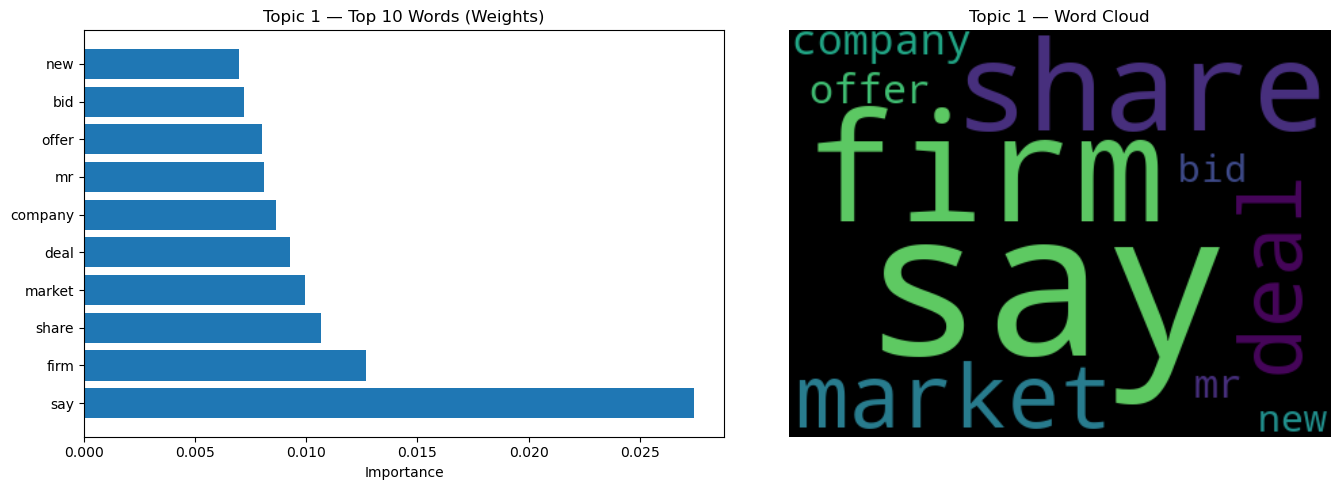

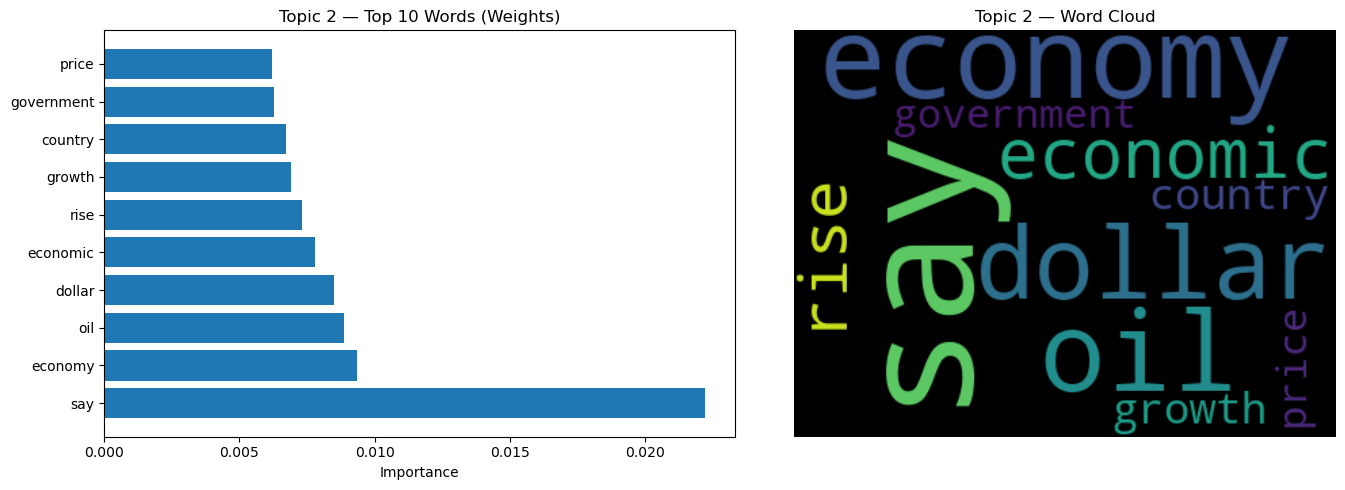

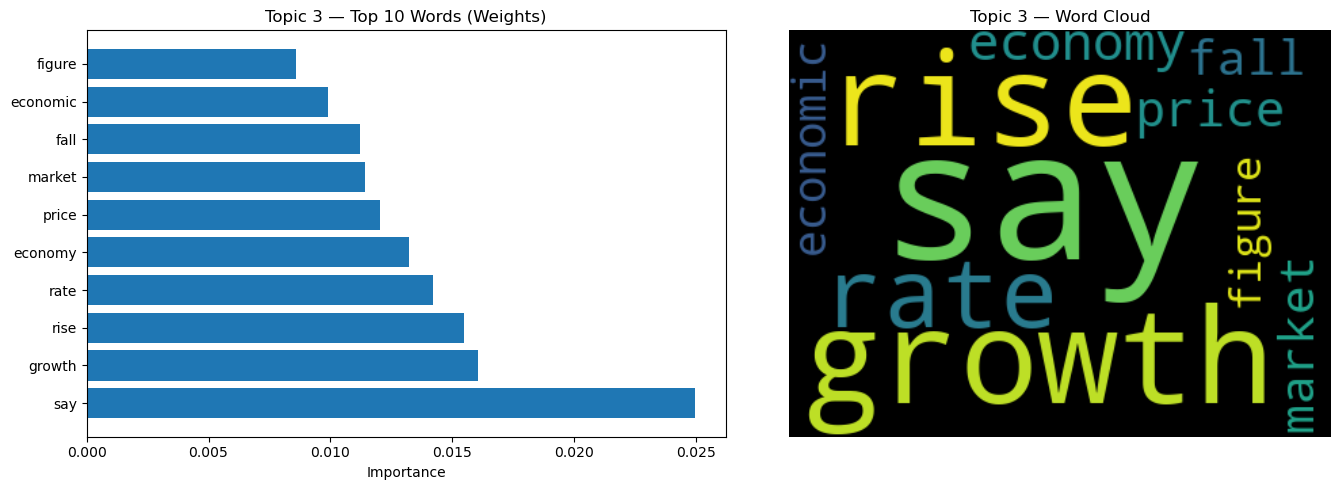

In [71]:
print_result(business_dataset)

#### Вывод:
 - Topic 0: say, company, mr, firm, sale, government, profit, state, executive, chief, court, share, claim, pay, bank, oil, country, tax, business, new
   <br>Бизнес и право. Ключевые слова связаны с бизнесом, государством, судами и налогами.
 - Topic 1: say, firm, share, market, deal, company, mr, offer, bid, new, buy, business, sale, car, shareholder, big, takeover, report, stake, profit
   <br>Финансовые сделки. Ключевые слова связаны с компаниями, акциями, рынками и сделками.
 - Topic 2: say, economy, oil, dollar, economic, rise, growth, country, government, price, rate, high, market, deficit, mr, world, trade, report, expect, analyst
   <br>Мировая экономика. Ключевые слова связаны с нефтью, долларами, экономикой...
 - Topic 3: say, growth, rise, rate, economy, price, market, fall, economic, figure, high, cost, expect, country, interest, consumer, job, strong, increase, economist
   <br>Экономическая аналитика. Это тема про экономическую статистику, отчёты, инфляцию, потребительские тренды.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Sport. LDA</h4>
</div>

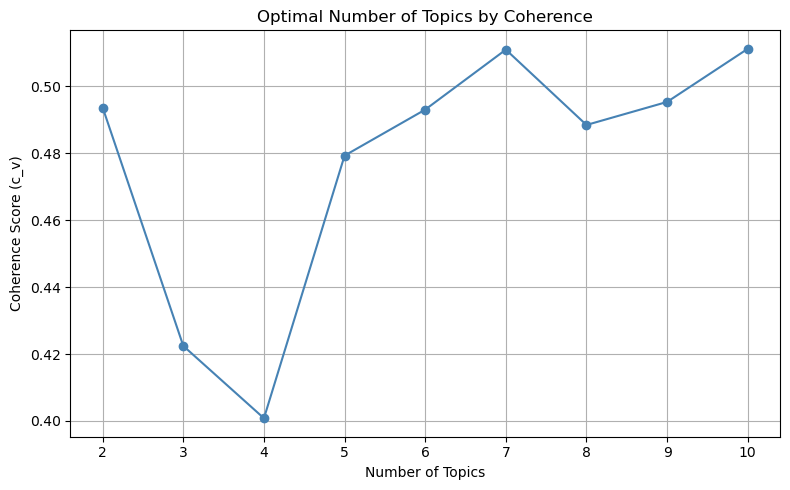

Best number of topics: 10 (coherence = 0.5112)
Training complete.
Topic 0: goal, ball, penalty, lead, time, try, kick, chance, score, shot, give, game, win, point, break, home, line, take, head, right
Topic 1: say, club, player, deal, want, take, new, bid, offer, contract, run, try, manager, come, like, add, play, work, coach, time
Topic 2: player, game, say, team, rugby, play, come, look, want, captain, injury, get, great, time, think, good, coach, win, add, start
Topic 3: say, win, play, player, game, good, time, team, think, match, come, go, want, get, great, goal, know, like, club, coach
Topic 4: say, club, game, player, striker, team, report, boss, tell, play, win, fine, come, fan, think, manager, follow, match, fa, action
Topic 5: win, race, say, good, world, title, time, man, final, record, run, medal, take, coach, champion, jump, gold, indoor, finish, woman
Topic 6: draw, say, round, play, face, home, tie, good, come, man, go, woman, win, think, beat, match, game, time, replay,

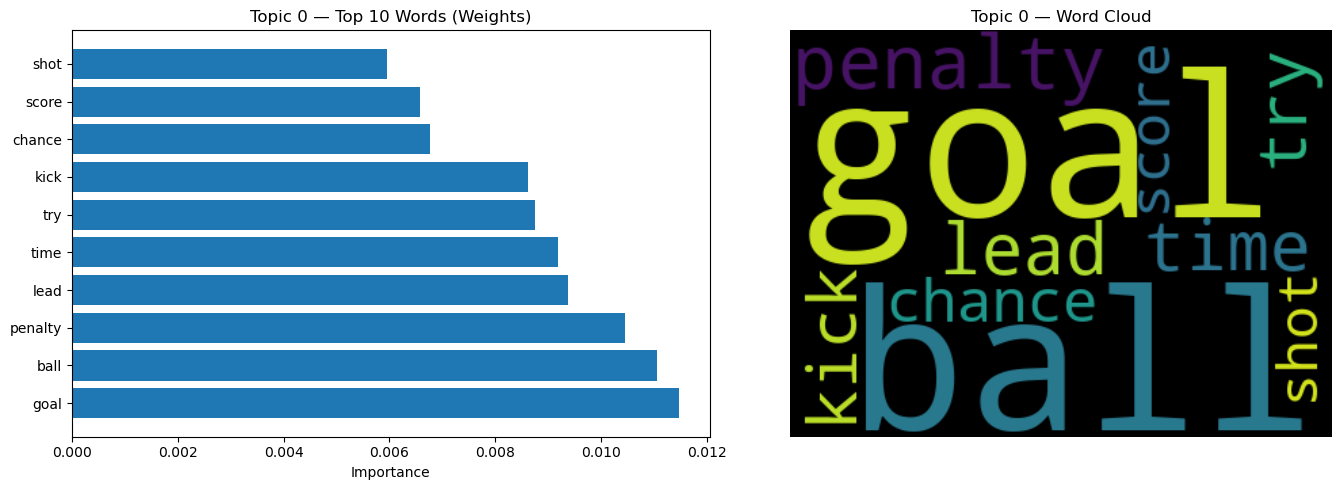

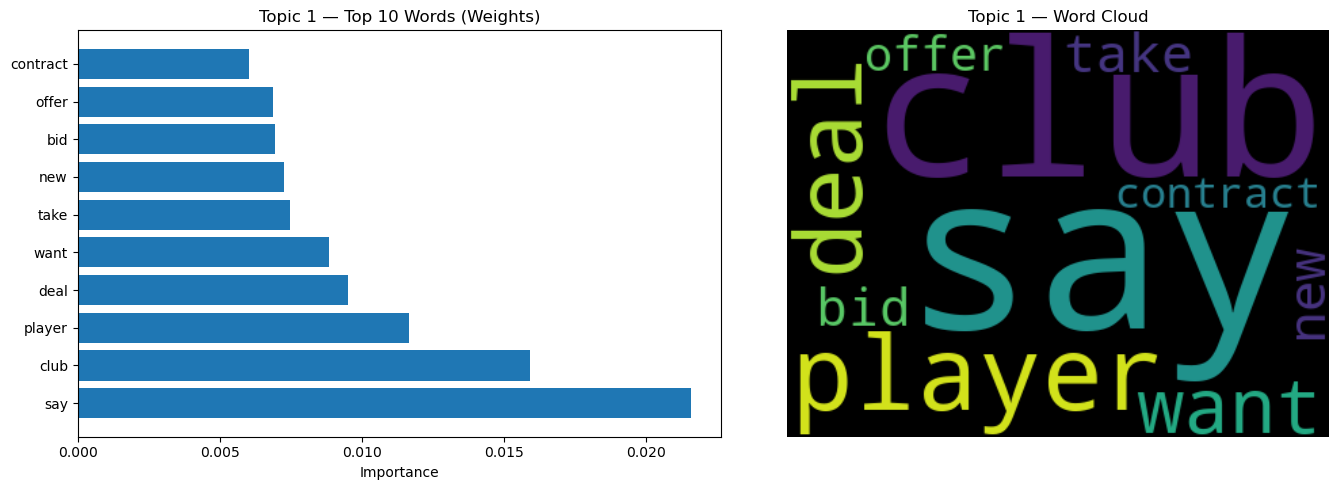

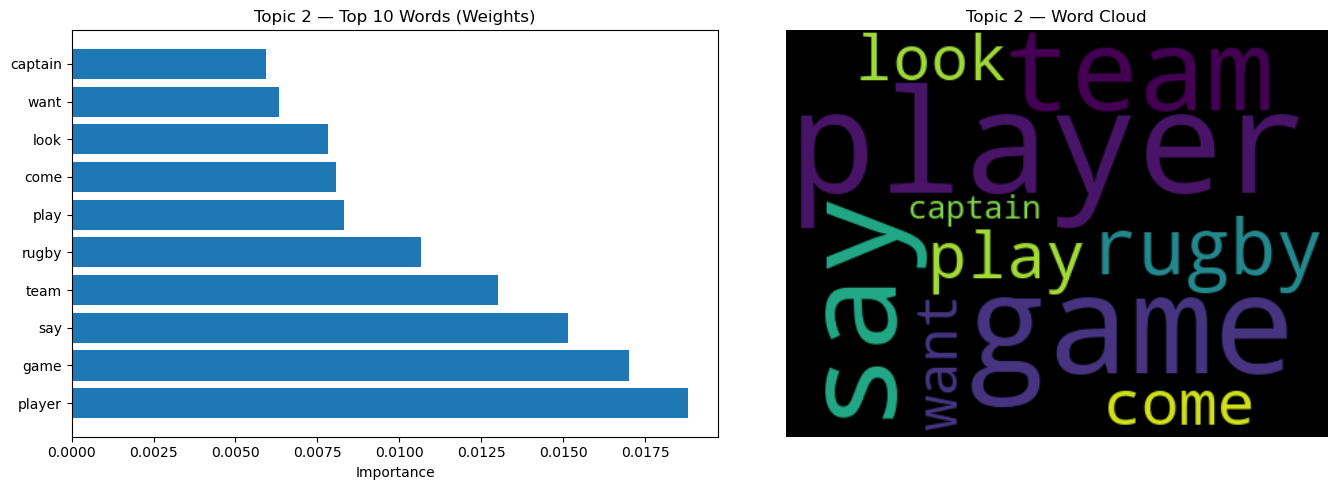

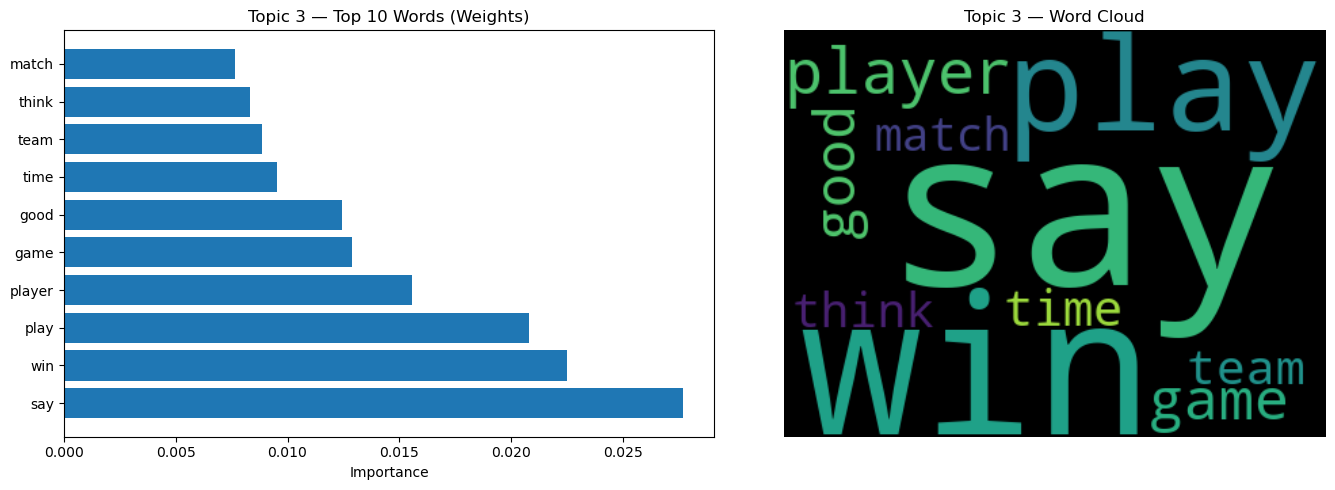

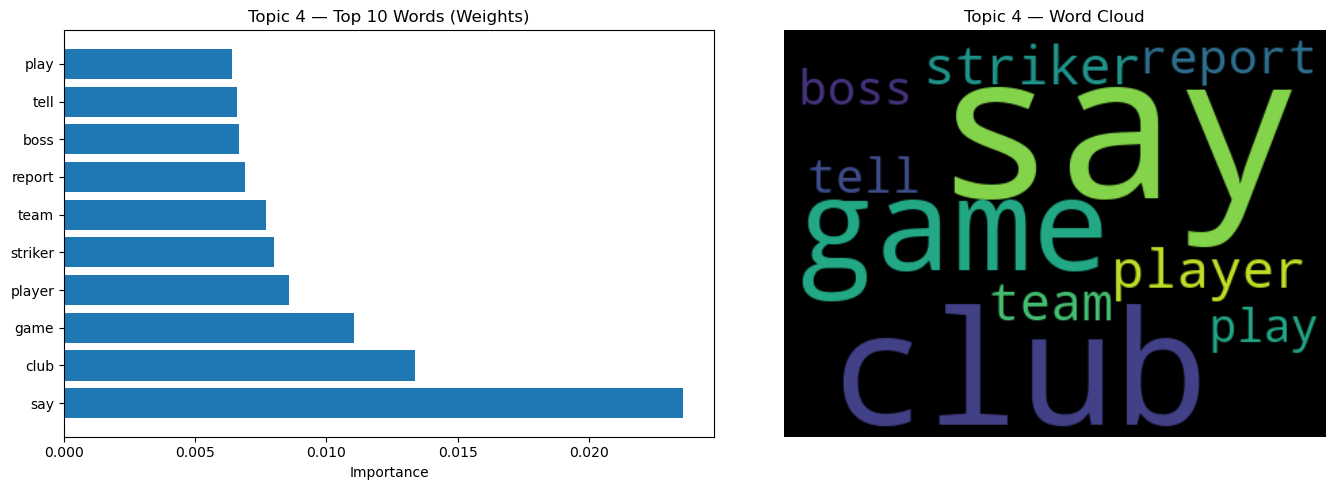

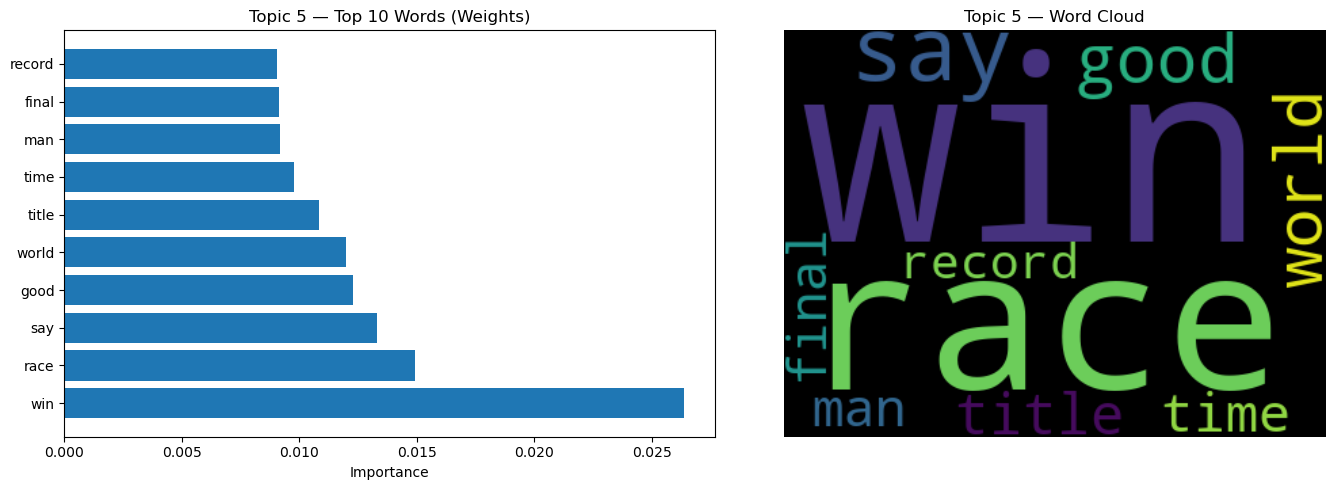

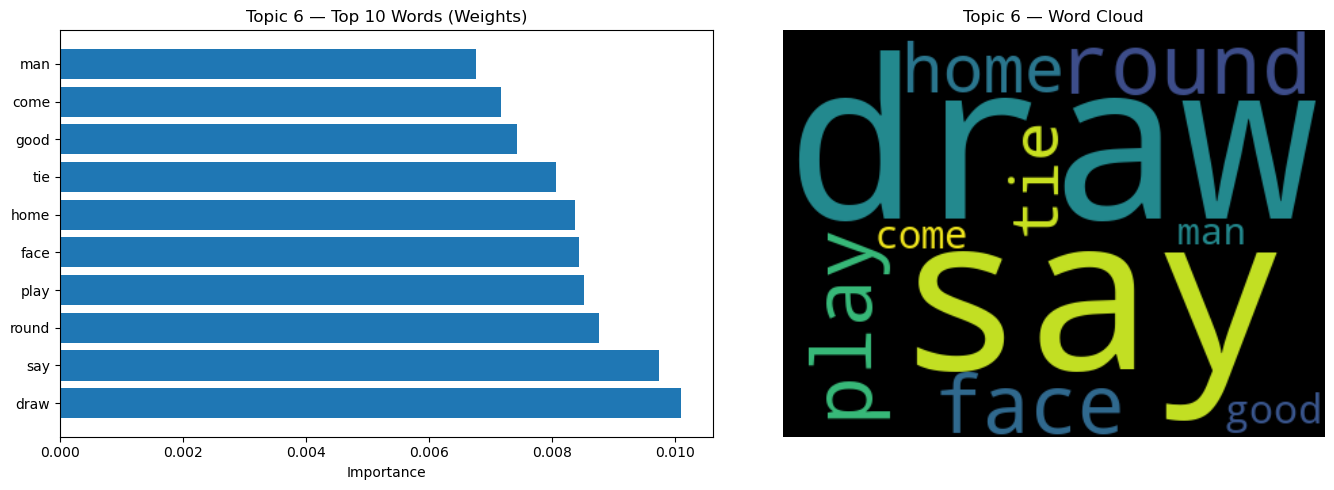

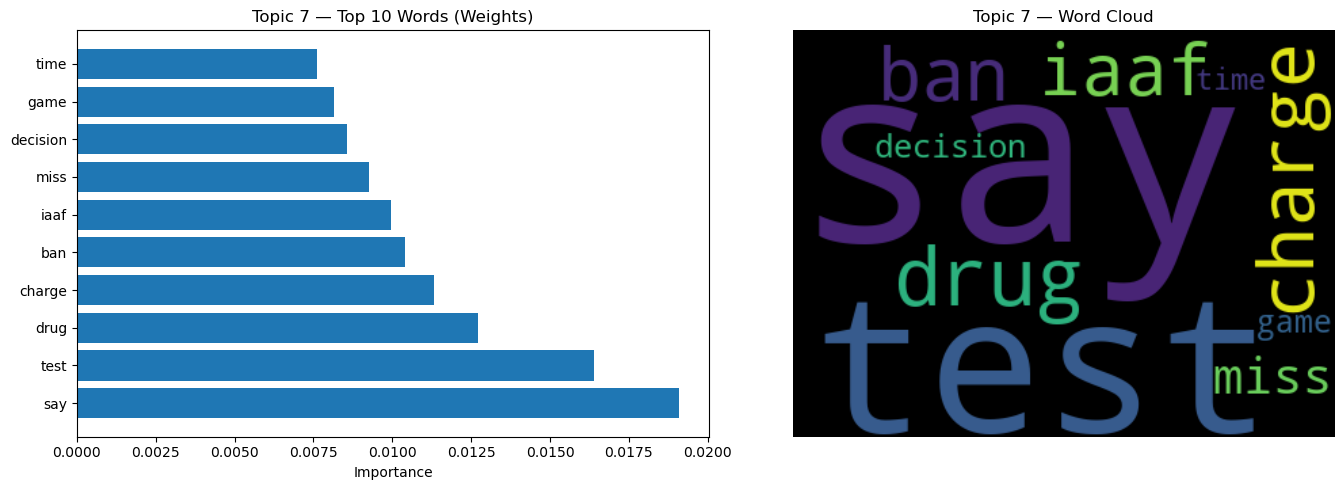

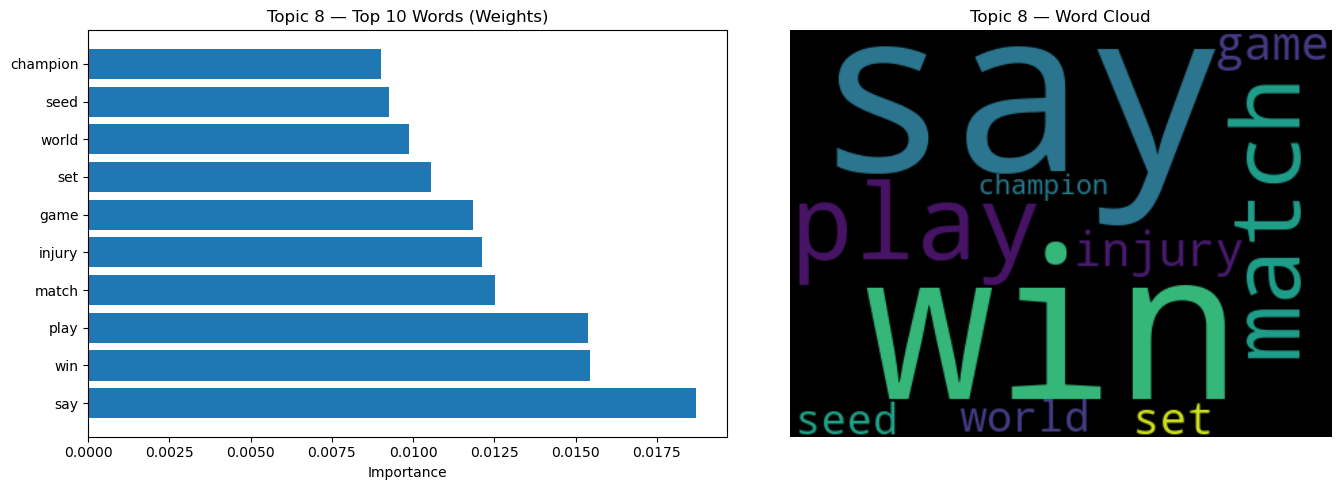

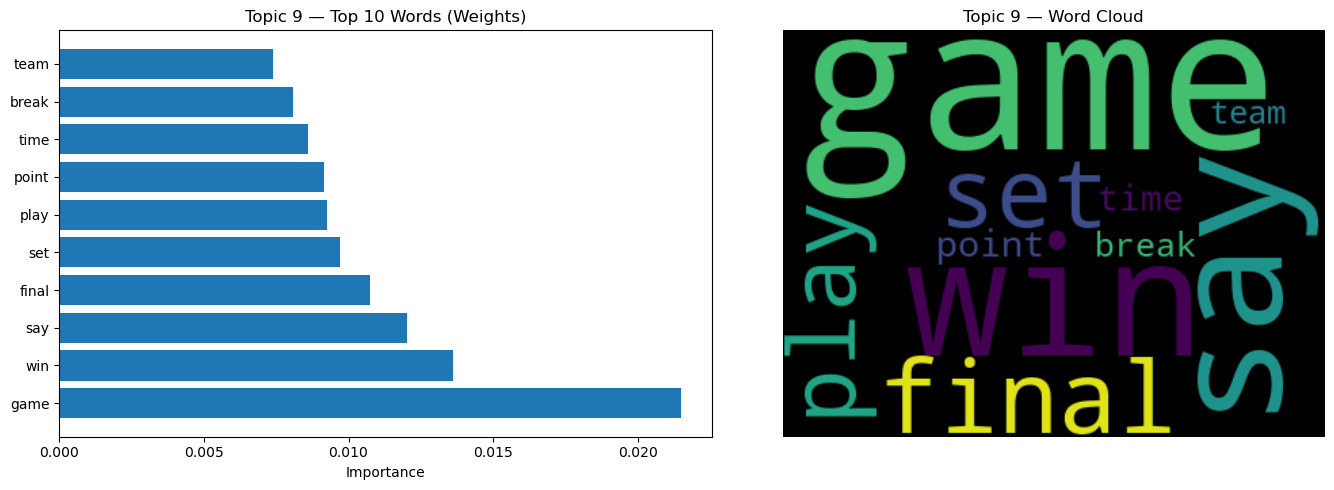

In [72]:
print_result(sport_dataset)

#### Вывод:
 - Topic 0: goal, ball, penalty, lead, time, try, kick, chance, score, shot, give, game, win, point, break, home, line, take, head, right
   <br>Футбол.
 - Topic 1: say, club, player, deal, want, take, new, bid, offer, contract, run, try, manager, come, like, add, play, work, coach, time
   <br>Трансферы.
 - Topic 2: player, game, say, team, rugby, play, come, look, want, captain, injury, get, great, time, think, good, coach, win, add, start
   <br>Регби.
 - Topic 3: say, win, play, player, game, good, time, team, think, match, come, go, want, get, great, goal, know, like, club, coach
   <br>Инервью и мнения.
 - Topic 4: say, club, game, player, striker, team, report, boss, tell, play, win, fine, come, fan, think, manager, follow, match, fa, action
   <br>Скандалы.
 - Topic 5: win, race, say, good, world, title, time, man, final, record, run, medal, take, coach, champion, jump, gold, indoor, finish, woman
   <br>Легкая атлетика.
 - Topic 6: draw, say, round, play, face, home, tie, good, come, man, go, woman, win, think, beat, match, game, time, replay, final
   <br>Кубки и ничьи.
 - Topic 7: say, test, drug, charge, ban, iaaf, miss, decision, game, time, club, athlete, face, sprinter, tell, coach, fail, suspend, expect, official
   <br>Допинг.
 - Topic 8: say, win, play, match, injury, game, set, world, seed, champion, final, beat, go, time, player, round, good, come, number, defeat
   <br>Теннис.
 - Topic 9: game, win, say, final, set, play, point, time, break, team, go, squad, good, match, hold, start, come, serve, take, lose
   <br>Соревнования, финальные очки.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Tech. LDA</h4>
</div>

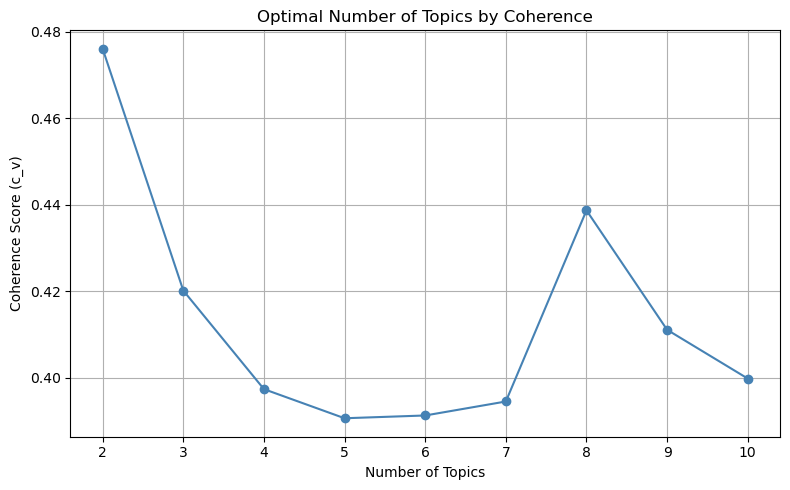

Best number of topics: 2 (coherence = 0.4761)
Training complete.
Topic 0: say, people, user, software, net, virus, site, firm, search, program, security, file, game, computer, use, company, system, mail, new, information
Topic 1: say, people, game, mobile, technology, phone, service, new, music, player, digital, mr, use, video, tv, device, like, high, computer, work


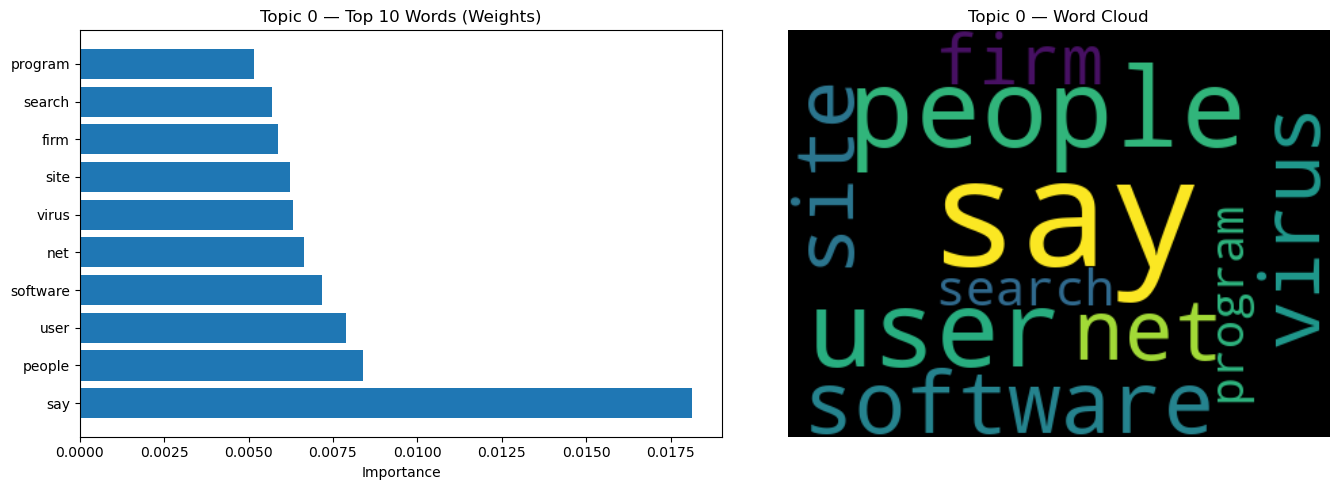

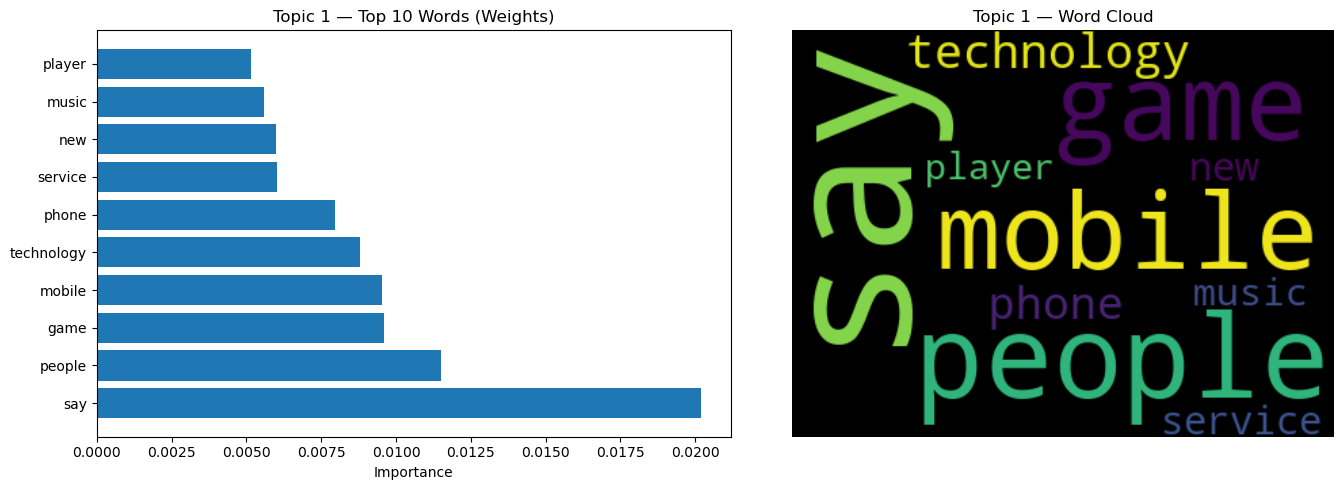

In [73]:
print_result(tech_dataset)

#### Вывод:
 - Topic 0: say, people, user, software, net, virus, site, firm, search, program, security, file, game, computer, use, company, system, mail, new, information
<br>Интернет, безопасность и программное обеспечение.
 - Topic 1: say, people, game, mobile, technology, phone, service, new, music, player, digital, mr, use, video, tv, device, like, high, computer, work
<br>Цифровые устройства и электроника.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Politics. LDA</h4>
</div>

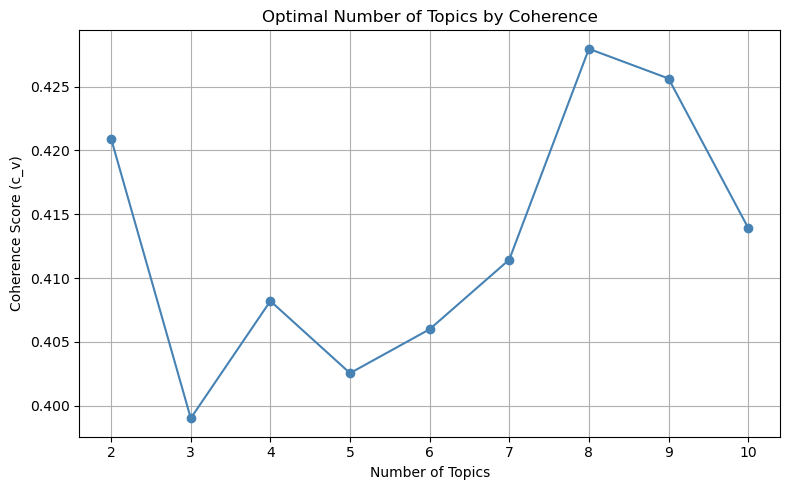

Best number of topics: 8 (coherence = 0.4280)
Training complete.
Topic 0: mr, say, election, party, minister, prime, campaign, chancellor, tell, claim, government, leader, people, new, general, issue, report, go, public, politic
Topic 1: say, lord, police, people, court, plan, minister, new, government, want, tell, chief, issue, judge, public, mr, power, chancellor, work, child
Topic 2: say, mr, government, law, lord, tell, secretary, minister, terror, home, people, man, right, case, suspect, plan, trial, new, rule, foreign
Topic 3: say, people, wage, card, id, increase, pay, minimum, party, student, mr, call, go, university, job, work, vote, business, plan, government
Topic 4: say, mr, people, government, minister, election, pension, vote, age, party, union, time, country, issue, want, minority, public, worker, work, add
Topic 5: say, government, tax, mr, plan, people, party, cut, public, election, council, minister, new, pay, increase, need, local, report, service, taxis
Topic 6: hun

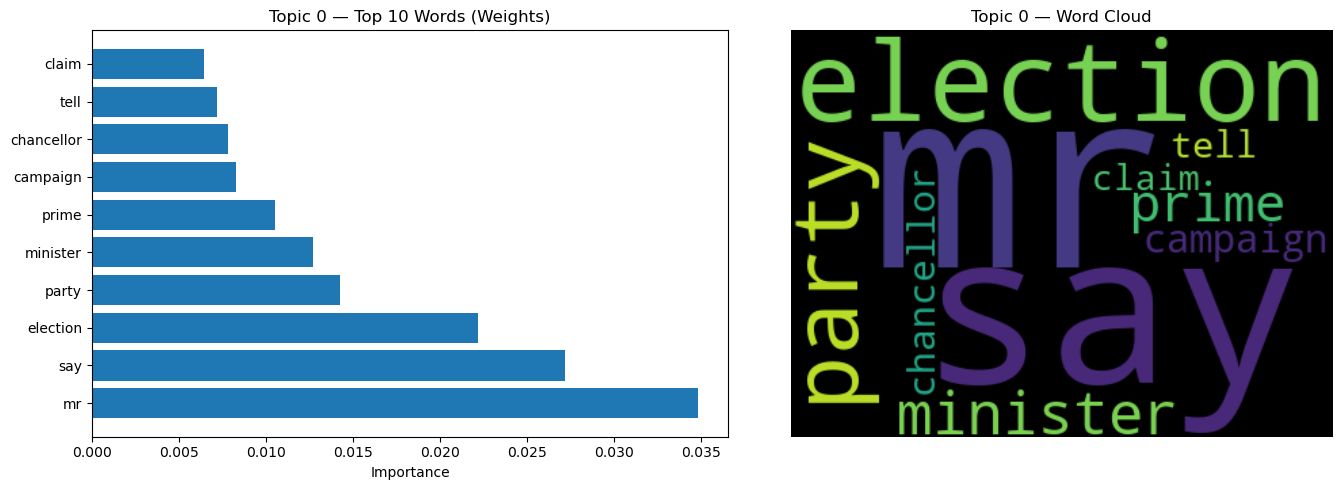

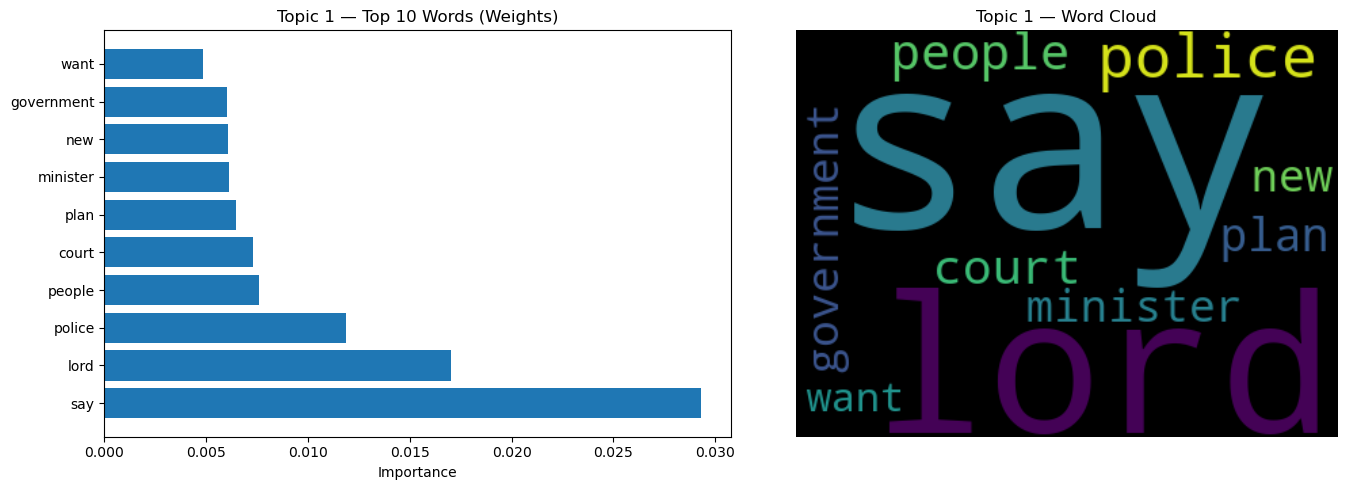

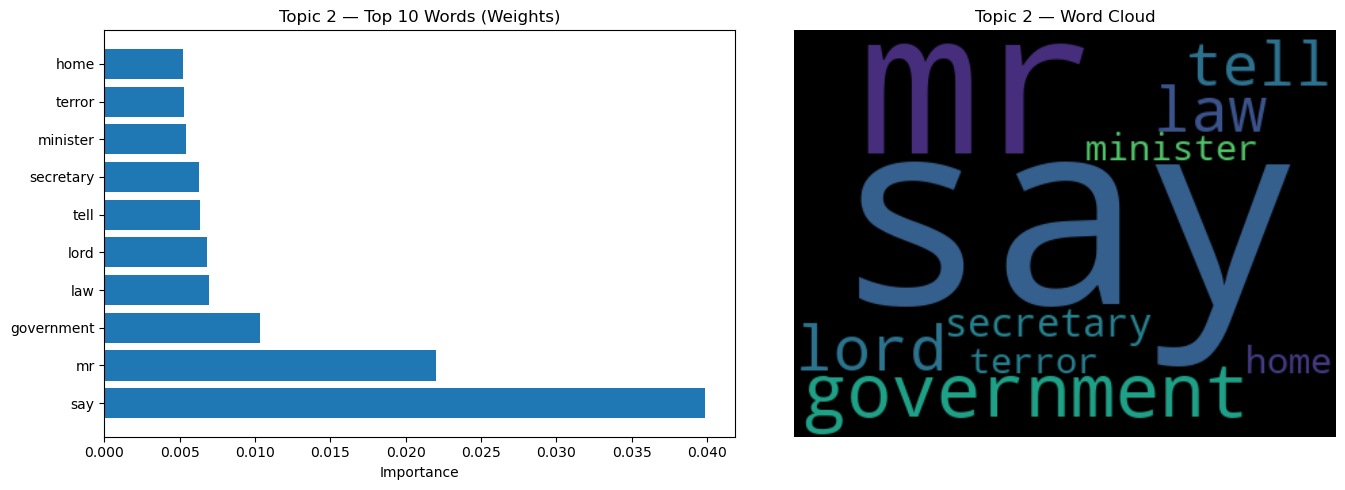

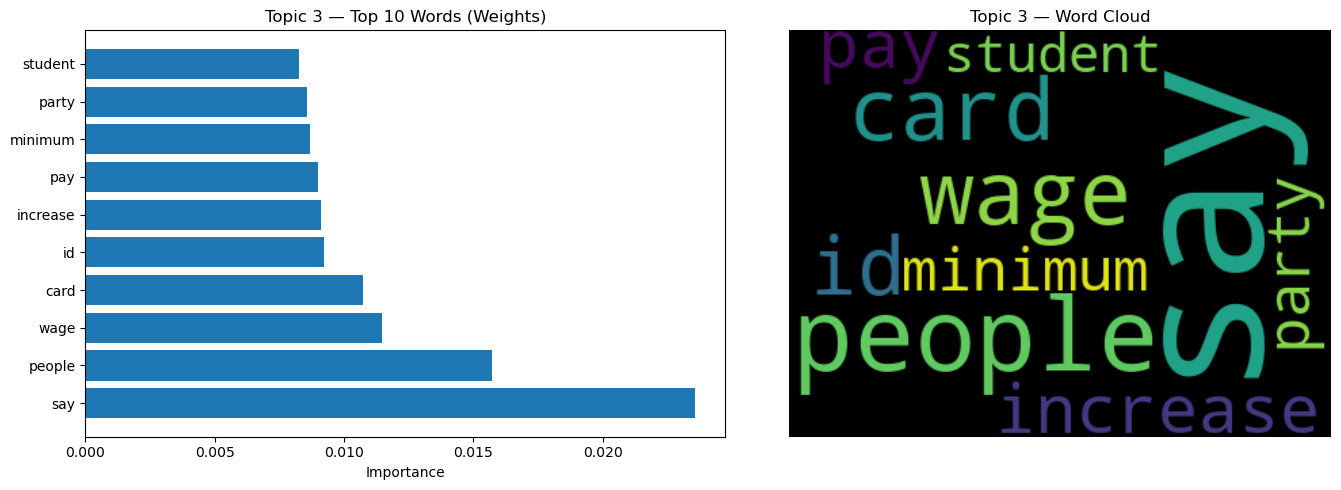

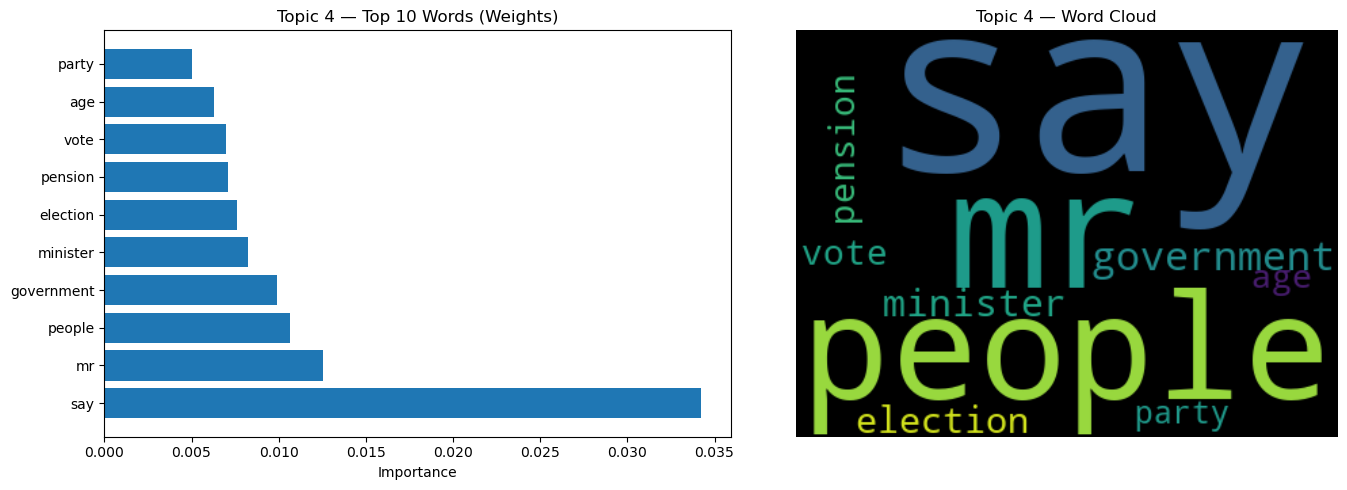

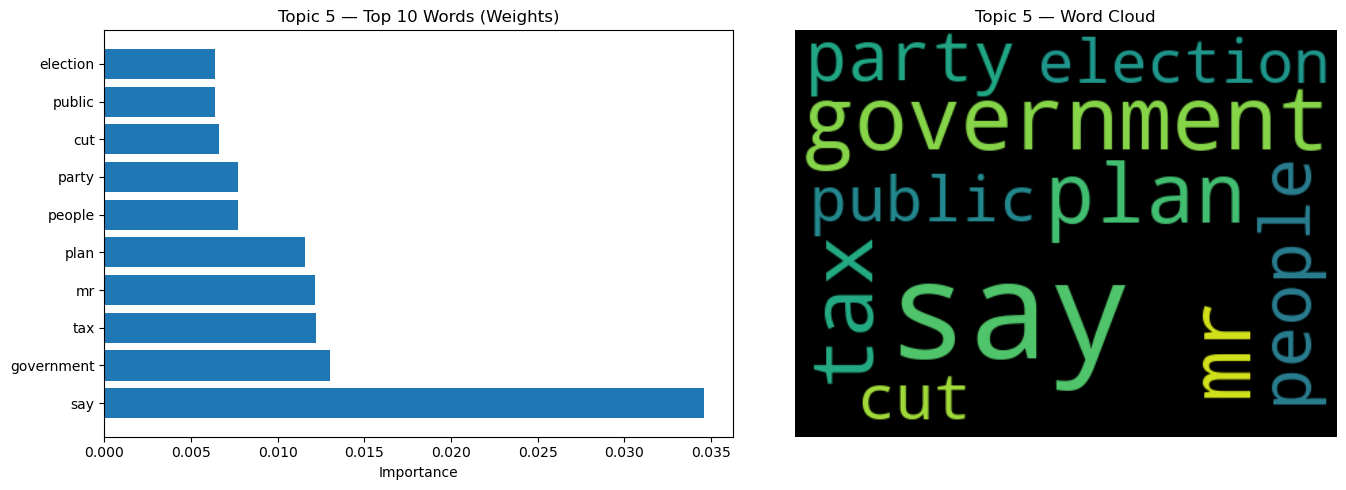

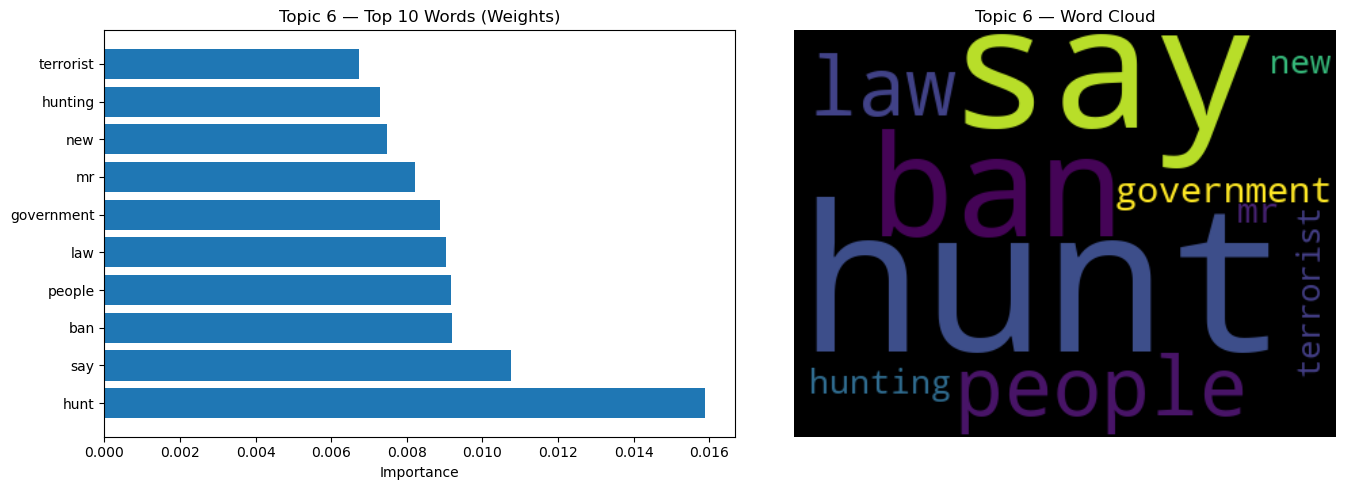

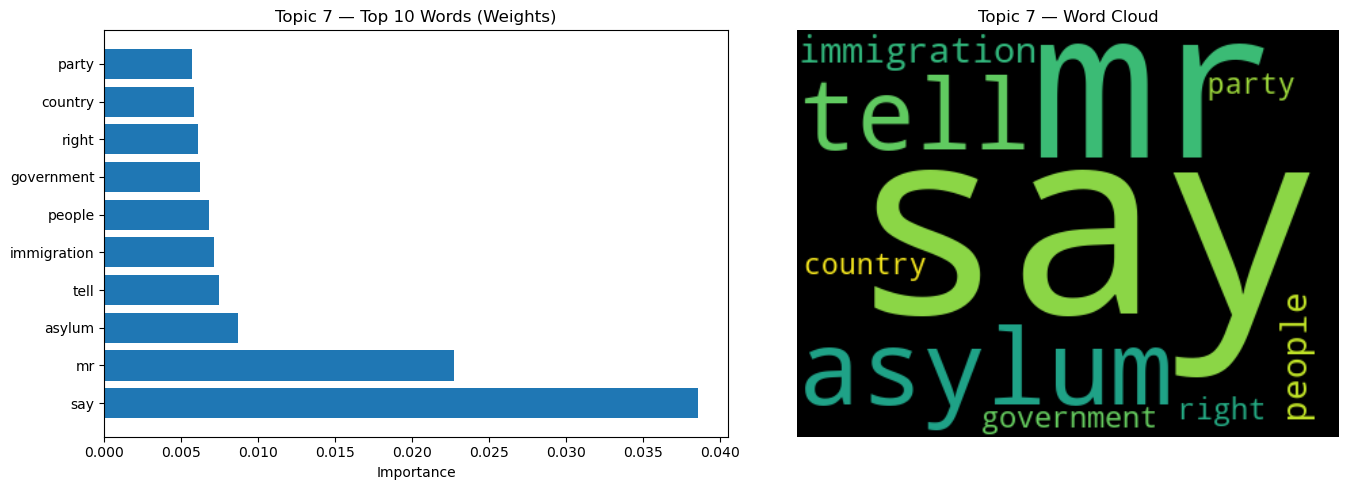

In [74]:
print_result(politics_dataset)

#### Вывод:
 - Topic 0: mr, say, election, party, minister, prime, campaign, chancellor, tell, claim, government, leader, people, new, general, issue, report, go, public, politic
   <br>Выборы
 - Topic 1: say, lord, police, people, court, plan, minister, new, government, want, tell, chief, issue, judge, public, mr, power, chancellor, work, child
   <br>Суд и законы
 - Topic 2: say, mr, government, law, lord, tell, secretary, minister, terror, home, people, man, right, case, suspect, plan, trial, new, rule, foreign
   <br>Безопасность и права
 - Topic 3: say, people, wage, card, id, increase, pay, minimum, party, student, mr, call, go, university, job, work, vote, business, plan, government
   <br>Социальные вопросы
 - Topic 4: say, mr, people, government, minister, election, pension, vote, age, party, union, time, country, issue, want, minority, public, worker, work, add
   <br>Пенсионная политика
 - Topic 5: say, government, tax, mr, plan, people, party, cut, public, election, council, minister, new, pay, increase, need, local, report, service, taxis
   <br>Налоги и бюджет
 - Topic 6: hunt, say, ban, people, law, government, mr, new, hunting, terrorist, police, threat, agree, like, tell, dog, go, come, right, place
   <br>Преступления
 - Topic 7: say, mr, asylum, tell, immigration, people, government, right, country, party, plan, want, claim, think, child, election, minister, leader, bill, constitution
   <br>Иммиграция

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Entertainment. LDA</h4>
</div>

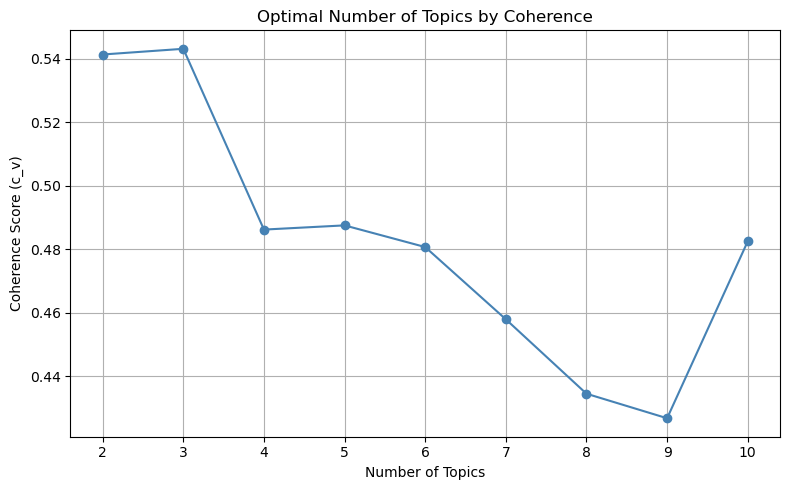

Best number of topics: 3 (coherence = 0.5431)
Training complete.
Topic 0: say, music, band, song, good, album, chart, include, number, single, record, win, new, singer, play, award, time, artist, release, people
Topic 1: say, film, star, play, musical, tv, role, actor, people, child, new, time, book, theatre, like, take, movie, big, series, tell
Topic 2: film, say, good, star, award, win, director, actor, include, actress, take, movie, comedy, nomination, prize, tv, mr, festival, box, office


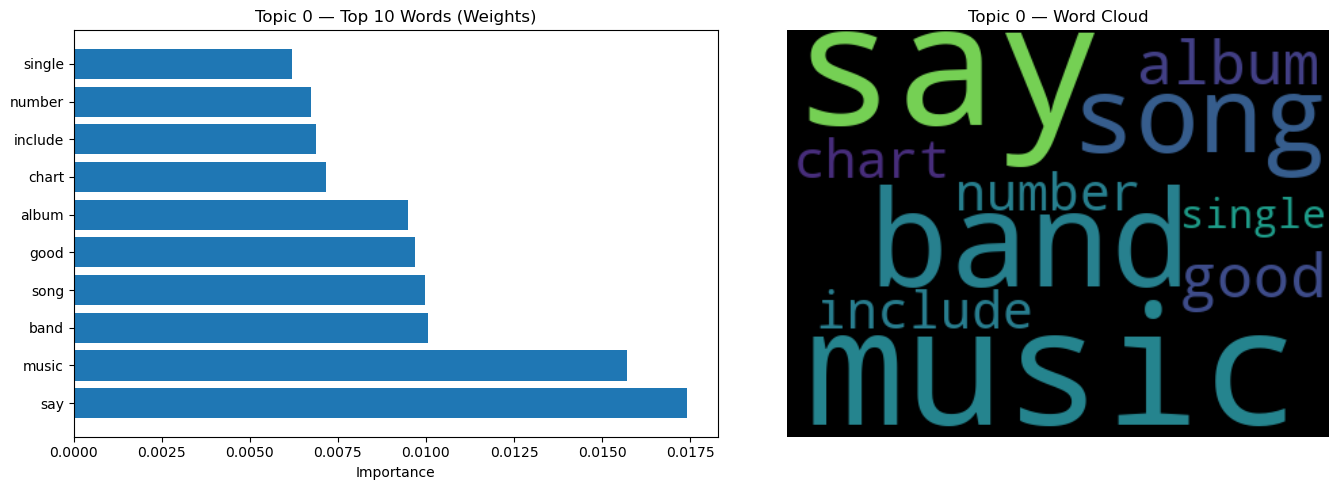

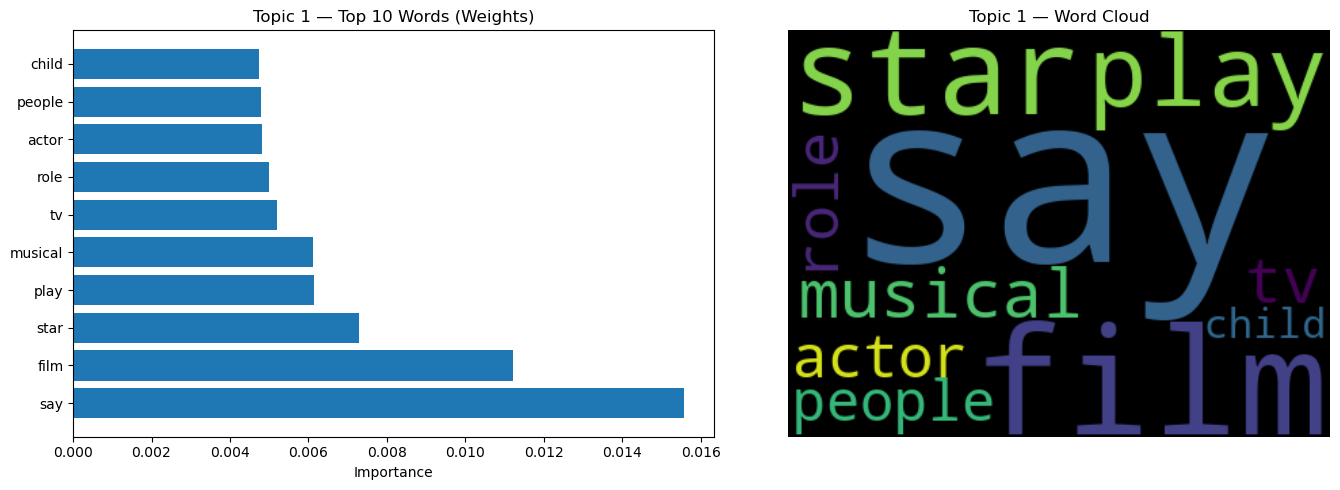

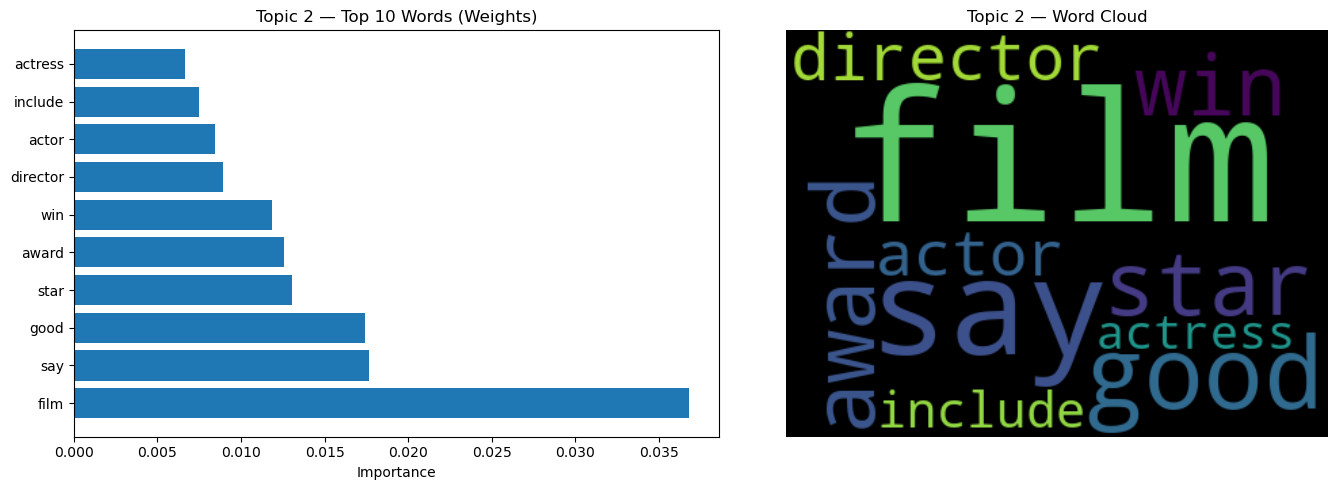

In [75]:
print_result(entertainment_dataset)

#### Вывод:
 - Topic 0: say, music, band, song, good, album, chart, include, number, single, record, win, new, singer, play, award, time, artist, release, people
   <br>Музыкальная индустрия
 - Topic 1: say, film, star, play, musical, tv, role, actor, people, child, new, time, book, theatre, like, take, movie, big, series, tell
   <br>Кино, ТВ и театр
 - Topic 2: film, say, good, star, award, win, director, actor, include, actress, take, movie, comedy, nomination, prize, tv, mr, festival, box, office
   <br>Фильмы и фестивали